<a href="https://colab.research.google.com/github/ZacharyZekaiXu/ZekaiXu_CrossmodalRecognition/blob/main/DDQN_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Whether bumble bee do mental 3D constructions to achieve the visual-tactile crossmodal recognition? 
An investigation into a biomimic framework that learns latent representation for crossmodal 3D reconstruction RL-tasks via active visual/tactile exploration 

Zekai Xu, Fengzhe Zhang - 
Imperial College London

# PreTraining

## Drive Mount
Original Repository from Github: git clone https://github.com/facebookresearch/Active-3D-Vision-and-Touch.git

The Modified Repository _ Google Drive Link: https://drive.google.com/drive/folders/1sv0n-2IIsGhgTlr6i6e5WS83lBSjnzif?usp=sharing

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Import & Setup


### conda

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

In [2]:
!conda --version

conda 4.14.0


In [4]:
%cd /content/gdrive/MyDrive/Active-3D-Vision-and-Touch/

/content/gdrive/MyDrive/Active-3D-Vision-and-Touch


### requirements Install

In [ ]:
!pip install -r requirements.txt

### pretained models and datasets

In [ ]:
!bash download_models.sh

In [ ]:
!bash download_data.sh

## DDQN - Training

In [ ]:
!pip install submitit

In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.12.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [ ]:
!pip install torch
import torch
!pip install trimesh
!pip install pyrender

Here we train a DDQN model in the touch only setting with grasping. This model leverages the latent space to learn actions.

In [ ]:
!pip3 install pybullet --upgrade
!pip3 install stable_baselines --upgrade
!pip3 install tensorflow #tensorflow deprecates and breaks their API
#see PyBullet Quickstart Guide at
#https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit
import imageio
import numpy as np



In [ ]:

!pip uninstall tensorboard
!pip uninstall tensorflow
!pip uninstall tensorboard
!pip uninstall tensorboardx
!pip uninstall tensorboard-plugin-wit
!pip uninstall cloud-tpu-client

!pip install tensorboard


In [11]:
from tensorboard import version
print(version.VERSION)

2.10.0


## Simulation Check

In [ ]:
!pip install rtree

/usr/local/lib/python3.7/site-packages/pytorch3d/io/obj_io.py:529: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")
/content/gdrive/MyDrive/Active-3D-Vision-and-Touch/pterotactyl/simulator/scene/instance.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  frame = {"pos": torch.FloatTensor(positions), "rot_M": torch.FloatTensor(rots)}


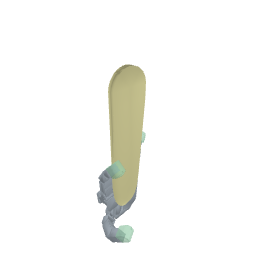

In [ ]:
import os
from PIL import Image
from pterotactyl.simulator.scene import sampler
from pterotactyl.simulator.physics import grasping
import pterotactyl.objects as objects

OBJ_LOCATION = os.path.join(os.path.dirname(objects.__file__), "test_objects/1")
batch = [OBJ_LOCATION]
s = sampler.Sampler(grasping.Agnostic_Grasp, bs=1, vision=True, resolution = [256, 256])
s.load_objects(batch, from_dataset=False, scale = 2.6)

action = [30]
parameters = [[[.3, .3, .3], [60, 0, 135]]]
signals = s.sample(action, touch=True, touch_point_cloud=False, vision=True, vision_occluded=True,parameters=parameters )

img_vision_grasp = Image.fromarray(signals["vision_occluded"][0])
display(img_vision_grasp)


# AutoEncoder

## AutoEncoder_Training Touch(Poking)


Here we train the autoencoder model in the touch only poking setting. This learns a latent space over the object predictions from the pretrained object prediction model in this setting.

In [ ]:
import os
from pterotactyl.reconstruction import touch 
from pterotactyl.reconstruction import vision 
from pterotactyl.reconstruction.autoencoder import train as auto_train 
from pterotactyl import pretrained

VISION_LOCATION = os.path.dirname(pretrained.__file__) + '/reconstruction/vision/t_p/'

class Params: # define training arguments 
    def __init__(self):
        self.cut = 0.33
        self.seed = 0 
        self.limit_data = True
        self.epochs = 5
        self.lr = 0.0003
        self.eval = False
        self.batch_size = 32
        self.number_points = 10000
        self.loss_coeff = 9000
        self.exp_id = "touch_false_img_true"
        self.exp_type = "test_fun"
        self.patience = 10
        self.finger = True 
        self.num_grasps = 5 
        self.hidden_GCN_size = 100
        self.num_GCN_layers = 5
        self.use_touch = True # using touch 
        self.use_img = False # not using vision 
        self.val_grasps = -1
        self.encoding_size = 50
        self.vision_location = VISION_LOCATION



params = Params()
auto_trainer = auto_train.Engine(params)
auto_trainer()

/usr/local/lib/python3.7/site-packages/pytorch3d/io/obj_io.py:529: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")
100%|██████████| 2000/2000 [00:01<00:00, 1597.42it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The number of auto_train set objects found : 557


100%|██████████| 2000/2000 [00:01<00:00, 1785.06it/s]


The number of valid set objects found : 745


  0%|          | 0/18 [02:46<?, ?it/s]


KeyError: ignored

## Autoencoder - Touch only Evaluation
Here we evaluate the pretrained touch only autoencoder model in the grasping setting. This will provide the reconstruction score on the test set.

# Touch Chart

## Touch Chart Reconstruction_Training

In [ ]:
from pterotactyl.reconstruction.touch import train as touch_train
class Params: # define training arguments 
    def __init__(self):
        self.seed = 0 
        self.limit_data = False
        self.epochs = 3 # ori = 30
        self.lr = 0.0001
        self.eval = False
        self.pretrained = False
        self.batch_size = 128
        self.num_samples = 4000
        self.loss_coeff = 9000
        self.exp_id = "233"
        self.exp_type = "example"
        self.patience = 10

params = Params()
touch_trainer = touch_train.Engine(params)
touch_trainer()

/usr/local/lib/python3.7/site-packages/pytorch3d/io/obj_io.py:529: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")
100%|██████████| 26782/26782 [13:21<00:00, 33.43it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The number of recon_train set objects found : 3495


100%|██████████| 26782/26782 [02:52<00:00, 155.16it/s]


The number of valid set objects found : 894


  7%|▋         | 2/28 [05:11<55:39, 128.43s/it]  

Train || Epoch: 0,  loss: 42.08130 || best_loss:  10000.00000
Train || Epoch: 0,  loss: 32.33865 || best_loss:  10000.00000


Train || Epoch: 0,  loss: 26.17622 || best_loss:  10000.00000
Train || Epoch: 0,  loss: 22.58704 || best_loss:  10000.00000


 21%|██▏       | 6/28 [05:12<07:56, 21.65s/it]

Train || Epoch: 0,  loss: 19.78127 || best_loss:  10000.00000
Train || Epoch: 0,  loss: 17.62390 || best_loss:  10000.00000


 29%|██▊       | 8/28 [05:12<03:37, 10.88s/it]

Train || Epoch: 0,  loss: 15.74279 || best_loss:  10000.00000
Train || Epoch: 0,  loss: 14.59991 || best_loss:  10000.00000


 36%|███▌      | 10/28 [05:12<01:37,  5.44s/it]

Train || Epoch: 0,  loss: 13.06103 || best_loss:  10000.00000
Train || Epoch: 0,  loss: 11.99555 || best_loss:  10000.00000


 43%|████▎     | 12/28 [05:12<00:43,  2.73s/it]

Train || Epoch: 0,  loss: 11.01961 || best_loss:  10000.00000
Train || Epoch: 0,  loss: 10.46986 || best_loss:  10000.00000


 50%|█████     | 14/28 [05:27<01:02,  4.45s/it]

Train || Epoch: 0,  loss: 9.95625 || best_loss:  10000.00000
Train || Epoch: 0,  loss: 9.48625 || best_loss:  10000.00000


 57%|█████▋    | 16/28 [05:27<00:26,  2.24s/it]

Train || Epoch: 0,  loss: 9.11988 || best_loss:  10000.00000
Train || Epoch: 0,  loss: 8.69778 || best_loss:  10000.00000


 64%|██████▍   | 18/28 [10:08<09:59, 59.98s/it]

Train || Epoch: 0,  loss: 8.08623 || best_loss:  10000.00000
Train || Epoch: 0,  loss: 7.70178 || best_loss:  10000.00000


 71%|███████▏  | 20/28 [10:12<04:02, 30.36s/it]

Train || Epoch: 0,  loss: 7.22954 || best_loss:  10000.00000
Train || Epoch: 0,  loss: 6.73736 || best_loss:  10000.00000


Train || Epoch: 0,  loss: 6.34617 || best_loss:  10000.00000
Train || Epoch: 0,  loss: 6.12574 || best_loss:  10000.00000


Train || Epoch: 0,  loss: 5.73723 || best_loss:  10000.00000
Train || Epoch: 0,  loss: 5.53773 || best_loss:  10000.00000
Train || Epoch: 0,  loss: 5.17182 || best_loss:  10000.00000

 93%|█████████▎| 26/28 [10:13<00:07,  3.66s/it]


Train || Epoch: 0,  loss: 4.97103 || best_loss:  10000.00000
Train || Epoch: 0,  loss: 4.55662 || best_loss:  10000.00000


100%|██████████| 28/28 [10:13<00:00,  2.01s/it]

Train || Epoch: 0,  loss: 4.51279 || best_loss:  10000.00000


100%|██████████| 7/7 [05:06<00:00, 43.76s/it]


*******************************************************
Total validation loss: 16.74884033203125
*******************************************************
Saving Model with a 9983.2509765625 improvement in point loss
*******************************************************


  4%|▎         | 1/28 [00:31<14:14, 31.65s/it]

Train || Epoch: 1,  loss: 4.13270 || best_loss:  16.74884


  7%|▋         | 2/28 [00:32<05:45, 13.30s/it]

Train || Epoch: 1,  loss: 3.78367 || best_loss:  16.74884


 11%|█         | 3/28 [00:32<03:04,  7.39s/it]

Train || Epoch: 1,  loss: 3.62598 || best_loss:  16.74884


 14%|█▍        | 4/28 [00:32<01:51,  4.63s/it]

Train || Epoch: 1,  loss: 3.41725 || best_loss:  16.74884


 18%|█▊        | 5/28 [00:33<01:10,  3.05s/it]

Train || Epoch: 1,  loss: 3.16031 || best_loss:  16.74884


 21%|██▏       | 6/28 [00:33<00:46,  2.13s/it]

Train || Epoch: 1,  loss: 3.05130 || best_loss:  16.74884


 25%|██▌       | 7/28 [00:33<00:31,  1.50s/it]

Train || Epoch: 1,  loss: 2.84495 || best_loss:  16.74884


 29%|██▊       | 8/28 [00:34<00:24,  1.21s/it]

Train || Epoch: 1,  loss: 2.61844 || best_loss:  16.74884


 32%|███▏      | 9/28 [00:34<00:17,  1.08it/s]

Train || Epoch: 1,  loss: 2.58216 || best_loss:  16.74884


 36%|███▌      | 10/28 [00:35<00:14,  1.27it/s]

Train || Epoch: 1,  loss: 2.42613 || best_loss:  16.74884


 43%|████▎     | 12/28 [00:35<00:08,  1.84it/s]

Train || Epoch: 1,  loss: 2.29919 || best_loss:  16.74884
Train || Epoch: 1,  loss: 2.00511 || best_loss:  16.74884


 50%|█████     | 14/28 [00:36<00:06,  2.26it/s]

Train || Epoch: 1,  loss: 1.91509 || best_loss:  16.74884
Train || Epoch: 1,  loss: 1.83964 || best_loss:  16.74884


 54%|█████▎    | 15/28 [00:36<00:04,  2.78it/s]

Train || Epoch: 1,  loss: 1.67771 || best_loss:  16.74884


 57%|█████▋    | 16/28 [00:36<00:04,  2.78it/s]

Train || Epoch: 1,  loss: 1.57899 || best_loss:  16.74884


 64%|██████▍   | 18/28 [00:52<00:33,  3.38s/it]

Train || Epoch: 1,  loss: 1.38108 || best_loss:  16.74884
Train || Epoch: 1,  loss: 1.31136 || best_loss:  16.74884


 68%|██████▊   | 19/28 [00:52<00:21,  2.40s/it]

Train || Epoch: 1,  loss: 1.30927 || best_loss:  16.74884
Train || Epoch: 1,  loss: 1.19086 || best_loss:  16.74884


Train || Epoch: 1,  loss: 1.02977 || best_loss:  16.74884
Train || Epoch: 1,  loss: 0.92968 || best_loss:  16.74884


Train || Epoch: 1,  loss: 0.99972 || best_loss:  16.74884
Train || Epoch: 1,  loss: 0.98286 || best_loss:  16.74884
Train || Epoch: 1,  loss: 0.76402 || best_loss:  16.74884


 96%|█████████▋| 27/28 [00:53<00:00,  3.48it/s]

Train || Epoch: 1,  loss: 0.80030 || best_loss:  16.74884
Train || Epoch: 1,  loss: 0.71819 || best_loss:  16.74884
Train || Epoch: 1,  loss: 0.70423 || best_loss:  16.74884


100%|██████████| 7/7 [00:15<00:00,  2.16s/it]


*******************************************************
Total validation loss: 1.0463342666625977
*******************************************************
Saving Model with a 15.702506065368652 improvement in point loss
*******************************************************


  4%|▎         | 1/28 [00:30<13:45, 30.58s/it]

Train || Epoch: 2,  loss: 0.58246 || best_loss:  1.04633


  7%|▋         | 2/28 [00:30<05:31, 12.76s/it]

Train || Epoch: 2,  loss: 0.62244 || best_loss:  1.04633


 11%|█         | 3/28 [00:31<02:56,  7.08s/it]

Train || Epoch: 2,  loss: 0.49236 || best_loss:  1.04633


 18%|█▊        | 5/28 [00:31<01:05,  2.86s/it]

Train || Epoch: 2,  loss: 0.46028 || best_loss:  1.04633
Train || Epoch: 2,  loss: 0.50253 || best_loss:  1.04633


 21%|██▏       | 6/28 [00:31<00:43,  1.96s/it]

Train || Epoch: 2,  loss: 0.42299 || best_loss:  1.04633


 25%|██▌       | 7/28 [00:32<00:29,  1.42s/it]

Train || Epoch: 2,  loss: 0.45785 || best_loss:  1.04633


 29%|██▊       | 8/28 [00:32<00:20,  1.04s/it]

Train || Epoch: 2,  loss: 0.43100 || best_loss:  1.04633


 32%|███▏      | 9/28 [00:32<00:15,  1.24it/s]

Train || Epoch: 2,  loss: 0.40910 || best_loss:  1.04633


 36%|███▌      | 10/28 [00:32<00:11,  1.53it/s]

Train || Epoch: 2,  loss: 0.36587 || best_loss:  1.04633


 39%|███▉      | 11/28 [00:33<00:09,  1.83it/s]

Train || Epoch: 2,  loss: 0.37005 || best_loss:  1.04633


 43%|████▎     | 12/28 [00:33<00:07,  2.13it/s]

Train || Epoch: 2,  loss: 0.28041 || best_loss:  1.04633


 46%|████▋     | 13/28 [00:33<00:06,  2.33it/s]

Train || Epoch: 2,  loss: 0.28019 || best_loss:  1.04633


 50%|█████     | 14/28 [00:34<00:05,  2.58it/s]

Train || Epoch: 2,  loss: 0.27817 || best_loss:  1.04633


 54%|█████▎    | 15/28 [00:34<00:04,  2.75it/s]

Train || Epoch: 2,  loss: 0.29101 || best_loss:  1.04633


 57%|█████▋    | 16/28 [00:34<00:03,  3.02it/s]

Train || Epoch: 2,  loss: 0.27034 || best_loss:  1.04633


 64%|██████▍   | 18/28 [00:51<00:37,  3.77s/it]

Train || Epoch: 2,  loss: 0.24789 || best_loss:  1.04633
Train || Epoch: 2,  loss: 0.25363 || best_loss:  1.04633


 71%|███████▏  | 20/28 [00:52<00:15,  1.90s/it]

Train || Epoch: 2,  loss: 0.19239 || best_loss:  1.04633
Train || Epoch: 2,  loss: 0.23710 || best_loss:  1.04633


 79%|███████▊  | 22/28 [00:52<00:05,  1.02it/s]

Train || Epoch: 2,  loss: 0.18949 || best_loss:  1.04633
Train || Epoch: 2,  loss: 0.17971 || best_loss:  1.04633


 86%|████████▌ | 24/28 [00:52<00:02,  1.86it/s]

Train || Epoch: 2,  loss: 0.17970 || best_loss:  1.04633
Train || Epoch: 2,  loss: 0.12865 || best_loss:  1.04633


Train || Epoch: 2,  loss: 0.20417 || best_loss:  1.04633
Train || Epoch: 2,  loss: 0.16559 || best_loss:  1.04633


 96%|█████████▋| 27/28 [00:52<00:00,  3.97it/s]

Train || Epoch: 2,  loss: 0.18633 || best_loss:  1.04633
Train || Epoch: 2,  loss: 0.09673 || best_loss:  1.04633


100%|██████████| 7/7 [00:14<00:00,  2.10s/it]

*******************************************************
Total validation loss: 0.17957960069179535
*******************************************************
Saving Model with a 0.8667546510696411 improvement in point loss
*******************************************************


## Touch Chart_Evaluation

In [ ]:
from pterotactyl.reconstruction.touch import train as touch_train 

params.eval = True
params.pretrained = False

touch_trainer = touch_train.Engine(params)
touch_trainer()

100%|██████████| 26782/26782 [01:33<00:00, 287.70it/s] 


The number of test set objects found : 454


100%|██████████| 4/4 [05:04<00:00, 76.25s/it]

*******************************************************
Total validation loss: 0.17325614392757416
*******************************************************


# Object Prediction

## Object Prediction_Training


In [ ]:
import os
from pterotactyl.reconstruction import touch 
from pterotactyl.reconstruction.vision import train as vision_train 
from pterotactyl import pretrained

TOUCH_LOCATION = os.path.dirname(pretrained.__file__) + '/reconstruction/touch/'

class Params: # define training arguments 
    def __init__(self):
        self.cut = 0.33
        self.seed = 0 
        self.limit_data = True
        self.epochs = 10 # ori = 30
        self.lr = 0.0003
        self.eval = False
        self.batch_size = 16
        self.number_points = 30000
        self.loss_coeff = 9000
        self.exp_id = "123"
        self.exp_type = "test"
        self.patience = 10
        self.visualize = False
        self.finger = True 
        self.num_grasps = 5 
        self.hidden_GCN_size = 300
        self.num_GCN_layers = 20 
        self.CNN_ker_size = 5 
        self.layers_per_block = 3 
        self.num_CNN_blocks = 6
        self.use_touch = True # using touch 
        self.use_img = False # not using vision 
        self.val_grasps = -1
        self.touch_location = TOUCH_LOCATION 
  

params = Params()
vision_trainer = vision_train.Engine(params)
vision_trainer()

100%|██████████| 2000/2000 [00:02<00:00, 914.32it/s]


The number of recon_train set objects found : 566


100%|██████████| 2000/2000 [00:01<00:00, 1790.47it/s]


The number of valid set objects found : 745


  3%|▎         | 1/36 [00:27<16:17, 27.94s/it]

Train || Epoch: 0, loss: 478.94, b_ptp:  10000.00


  6%|▌         | 2/36 [00:34<09:43, 17.16s/it]

Train || Epoch: 0, loss: 263.62, b_ptp:  10000.00


  8%|▊         | 3/36 [00:34<06:23, 11.64s/it]

Train || Epoch: 0, loss: 319.86, b_ptp:  10000.00


 11%|█         | 4/36 [00:35<04:44,  8.88s/it]

Train || Epoch: 0, loss: 273.12, b_ptp:  10000.00


 14%|█▍        | 5/36 [00:36<03:43,  7.22s/it]

Train || Epoch: 0, loss: 296.82, b_ptp:  10000.00


 17%|█▋        | 6/36 [00:36<03:03,  6.12s/it]

Train || Epoch: 0, loss: 316.63, b_ptp:  10000.00


 19%|█▉        | 7/36 [00:37<02:34,  5.34s/it]

Train || Epoch: 0, loss: 313.80, b_ptp:  10000.00


 22%|██▏       | 8/36 [00:37<02:12,  4.74s/it]

Train || Epoch: 0, loss: 343.43, b_ptp:  10000.00


 25%|██▌       | 9/36 [00:38<01:55,  4.29s/it]

Train || Epoch: 0, loss: 281.81, b_ptp:  10000.00


 28%|██▊       | 10/36 [00:39<01:41,  3.92s/it]

Train || Epoch: 0, loss: 259.16, b_ptp:  10000.00


 31%|███       | 11/36 [00:39<01:30,  3.62s/it]

Train || Epoch: 0, loss: 264.40, b_ptp:  10000.00


 33%|███▎      | 12/36 [00:40<01:20,  3.37s/it]

Train || Epoch: 0, loss: 271.61, b_ptp:  10000.00


 36%|███▌      | 13/36 [00:41<01:12,  3.16s/it]

Train || Epoch: 0, loss: 264.30, b_ptp:  10000.00


 39%|███▉      | 14/36 [00:41<01:05,  2.99s/it]

Train || Epoch: 0, loss: 304.90, b_ptp:  10000.00


 42%|████▏     | 15/36 [00:42<00:59,  2.83s/it]

Train || Epoch: 0, loss: 329.51, b_ptp:  10000.00


 44%|████▍     | 16/36 [00:43<00:53,  2.69s/it]

Train || Epoch: 0, loss: 283.69, b_ptp:  10000.00


 47%|████▋     | 17/36 [00:47<00:53,  2.79s/it]

Train || Epoch: 0, loss: 298.67, b_ptp:  10000.00


 50%|█████     | 18/36 [00:54<00:54,  3.03s/it]

Train || Epoch: 0, loss: 256.97, b_ptp:  10000.00


 53%|█████▎    | 19/36 [00:55<00:49,  2.90s/it]

Train || Epoch: 0, loss: 253.14, b_ptp:  10000.00


 56%|█████▌    | 20/36 [00:55<00:44,  2.79s/it]

Train || Epoch: 0, loss: 303.76, b_ptp:  10000.00


 58%|█████▊    | 21/36 [00:56<00:40,  2.68s/it]

Train || Epoch: 0, loss: 297.79, b_ptp:  10000.00


 61%|██████    | 22/36 [00:56<00:36,  2.59s/it]

Train || Epoch: 0, loss: 290.78, b_ptp:  10000.00


 64%|██████▍   | 23/36 [00:57<00:32,  2.50s/it]

Train || Epoch: 0, loss: 272.89, b_ptp:  10000.00


 67%|██████▋   | 24/36 [00:58<00:29,  2.42s/it]

Train || Epoch: 0, loss: 291.27, b_ptp:  10000.00


 69%|██████▉   | 25/36 [00:58<00:25,  2.35s/it]

Train || Epoch: 0, loss: 310.38, b_ptp:  10000.00


 72%|███████▏  | 26/36 [00:59<00:22,  2.28s/it]

Train || Epoch: 0, loss: 259.70, b_ptp:  10000.00


 75%|███████▌  | 27/36 [00:59<00:19,  2.21s/it]

Train || Epoch: 0, loss: 278.39, b_ptp:  10000.00


 78%|███████▊  | 28/36 [01:00<00:17,  2.16s/it]

Train || Epoch: 0, loss: 329.15, b_ptp:  10000.00


 81%|████████  | 29/36 [01:00<00:14,  2.10s/it]

Train || Epoch: 0, loss: 332.60, b_ptp:  10000.00


 83%|████████▎ | 30/36 [01:01<00:12,  2.05s/it]

Train || Epoch: 0, loss: 274.71, b_ptp:  10000.00


 86%|████████▌ | 31/36 [01:02<00:10,  2.00s/it]

Train || Epoch: 0, loss: 309.94, b_ptp:  10000.00


 89%|████████▉ | 32/36 [01:02<00:07,  1.96s/it]

Train || Epoch: 0, loss: 322.93, b_ptp:  10000.00


 92%|█████████▏| 33/36 [01:03<00:05,  1.92s/it]

Train || Epoch: 0, loss: 273.04, b_ptp:  10000.00


 94%|█████████▍| 34/36 [01:05<00:03,  1.91s/it]

Train || Epoch: 0, loss: 294.98, b_ptp:  10000.00


 97%|█████████▋| 35/36 [01:05<00:01,  1.88s/it]

Train || Epoch: 0, loss: 263.09, b_ptp:  10000.00


100%|██████████| 36/36 [01:05<00:00,  1.83s/it]

Train || Epoch: 0, loss: 281.02, b_ptp:  10000.00


  2%|▏         | 1/47 [00:10<07:49, 10.21s/it]

Valid || Epoch: 0, ave: 303.8295, b_ptp:  10000.00


  4%|▍         | 2/47 [00:11<03:45,  5.02s/it]

Valid || Epoch: 0, ave: 330.4238, b_ptp:  10000.00


  6%|▋         | 3/47 [00:12<02:26,  3.33s/it]

Valid || Epoch: 0, ave: 346.1930, b_ptp:  10000.00


  9%|▊         | 4/47 [00:14<01:51,  2.59s/it]

Valid || Epoch: 0, ave: 339.9989, b_ptp:  10000.00


 11%|█         | 5/47 [00:15<01:30,  2.15s/it]

Valid || Epoch: 0, ave: 320.8960, b_ptp:  10000.00


 13%|█▎        | 6/47 [00:16<01:14,  1.81s/it]

Valid || Epoch: 0, ave: 316.7709, b_ptp:  10000.00


 15%|█▍        | 7/47 [00:18<01:04,  1.61s/it]

Valid || Epoch: 0, ave: 312.1922, b_ptp:  10000.00


 17%|█▋        | 8/47 [00:18<00:52,  1.35s/it]

Valid || Epoch: 0, ave: 311.4821, b_ptp:  10000.00


 19%|█▉        | 9/47 [00:19<00:45,  1.19s/it]

Valid || Epoch: 0, ave: 308.0950, b_ptp:  10000.00


 21%|██▏       | 10/47 [00:20<00:41,  1.11s/it]

Valid || Epoch: 0, ave: 299.9310, b_ptp:  10000.00


 23%|██▎       | 11/47 [00:21<00:40,  1.12s/it]

Valid || Epoch: 0, ave: 309.5413, b_ptp:  10000.00


 26%|██▌       | 12/47 [00:22<00:37,  1.06s/it]

Valid || Epoch: 0, ave: 304.9500, b_ptp:  10000.00


 28%|██▊       | 13/47 [00:23<00:32,  1.04it/s]

Valid || Epoch: 0, ave: 306.2737, b_ptp:  10000.00


 30%|██▉       | 14/47 [00:24<00:28,  1.17it/s]

Valid || Epoch: 0, ave: 306.7087, b_ptp:  10000.00


 32%|███▏      | 15/47 [00:24<00:24,  1.29it/s]

Valid || Epoch: 0, ave: 308.3073, b_ptp:  10000.00


 34%|███▍      | 16/47 [00:25<00:21,  1.42it/s]

Valid || Epoch: 0, ave: 307.1812, b_ptp:  10000.00


 36%|███▌      | 17/47 [00:25<00:20,  1.50it/s]

Valid || Epoch: 0, ave: 311.6796, b_ptp:  10000.00


 38%|███▊      | 18/47 [00:26<00:16,  1.75it/s]

Valid || Epoch: 0, ave: 316.1544, b_ptp:  10000.00


 40%|████      | 19/47 [00:26<00:14,  1.98it/s]

Valid || Epoch: 0, ave: 310.4984, b_ptp:  10000.00


 43%|████▎     | 20/47 [00:26<00:12,  2.18it/s]

Valid || Epoch: 0, ave: 308.6893, b_ptp:  10000.00


 45%|████▍     | 21/47 [00:27<00:11,  2.34it/s]

Valid || Epoch: 0, ave: 309.1175, b_ptp:  10000.00


 47%|████▋     | 22/47 [00:27<00:10,  2.48it/s]

Valid || Epoch: 0, ave: 307.6440, b_ptp:  10000.00


 49%|████▉     | 23/47 [00:27<00:09,  2.59it/s]

Valid || Epoch: 0, ave: 305.5141, b_ptp:  10000.00


 51%|█████     | 24/47 [00:28<00:08,  2.65it/s]

Valid || Epoch: 0, ave: 306.4706, b_ptp:  10000.00


 53%|█████▎    | 25/47 [00:28<00:08,  2.72it/s]

Valid || Epoch: 0, ave: 309.2186, b_ptp:  10000.00


 55%|█████▌    | 26/47 [00:28<00:07,  2.78it/s]

Valid || Epoch: 0, ave: 306.0832, b_ptp:  10000.00


 57%|█████▋    | 27/47 [00:29<00:07,  2.82it/s]

Valid || Epoch: 0, ave: 305.8466, b_ptp:  10000.00


 60%|█████▉    | 28/47 [00:29<00:06,  2.85it/s]

Valid || Epoch: 0, ave: 304.9643, b_ptp:  10000.00


 62%|██████▏   | 29/47 [00:29<00:06,  2.87it/s]

Valid || Epoch: 0, ave: 303.6746, b_ptp:  10000.00


 64%|██████▍   | 30/47 [00:30<00:05,  2.88it/s]

Valid || Epoch: 0, ave: 301.7709, b_ptp:  10000.00


 66%|██████▌   | 31/47 [00:30<00:05,  2.88it/s]

Valid || Epoch: 0, ave: 300.0692, b_ptp:  10000.00


 68%|██████▊   | 32/47 [00:30<00:05,  2.89it/s]

Valid || Epoch: 0, ave: 298.8040, b_ptp:  10000.00


 70%|███████   | 33/47 [00:31<00:04,  2.87it/s]

Valid || Epoch: 0, ave: 297.4017, b_ptp:  10000.00


 72%|███████▏  | 34/47 [00:31<00:04,  2.88it/s]

Valid || Epoch: 0, ave: 295.1570, b_ptp:  10000.00


 74%|███████▍  | 35/47 [00:32<00:04,  2.88it/s]

Valid || Epoch: 0, ave: 296.6474, b_ptp:  10000.00


 77%|███████▋  | 36/47 [00:32<00:03,  2.90it/s]

Valid || Epoch: 0, ave: 295.0519, b_ptp:  10000.00


 79%|███████▊  | 37/47 [00:32<00:03,  2.88it/s]

Valid || Epoch: 0, ave: 294.6693, b_ptp:  10000.00


 81%|████████  | 38/47 [00:33<00:03,  2.90it/s]

Valid || Epoch: 0, ave: 296.1051, b_ptp:  10000.00


 83%|████████▎ | 39/47 [00:33<00:02,  2.88it/s]

Valid || Epoch: 0, ave: 295.9037, b_ptp:  10000.00


 85%|████████▌ | 40/47 [00:33<00:02,  2.90it/s]

Valid || Epoch: 0, ave: 294.9700, b_ptp:  10000.00


 87%|████████▋ | 41/47 [00:34<00:02,  2.90it/s]

Valid || Epoch: 0, ave: 294.5134, b_ptp:  10000.00


 89%|████████▉ | 42/47 [00:34<00:01,  2.89it/s]

Valid || Epoch: 0, ave: 293.3456, b_ptp:  10000.00


 91%|█████████▏| 43/47 [00:34<00:01,  2.90it/s]

Valid || Epoch: 0, ave: 292.0564, b_ptp:  10000.00


 94%|█████████▎| 44/47 [00:35<00:01,  2.90it/s]

Valid || Epoch: 0, ave: 293.6887, b_ptp:  10000.00


 96%|█████████▌| 45/47 [00:35<00:00,  2.90it/s]

Valid || Epoch: 0, ave: 293.6811, b_ptp:  10000.00


 98%|█████████▊| 46/47 [00:35<00:00,  2.88it/s]

Valid || Epoch: 0, ave: 293.1227, b_ptp:  10000.00


100%|██████████| 47/47 [00:36<00:00,  3.25it/s]

Valid || Epoch: 0, ave: 293.6130, b_ptp:  10000.00


100%|██████████| 47/47 [00:36<00:00,  1.28it/s]


*******************************************************
Validation Accuracy: 293.6130065917969
*******************************************************
Saving with 9706.387 improvement in Chamfer Distance on Validation Set 


  3%|▎         | 1/36 [00:10<06:23, 10.95s/it]

Train || Epoch: 1, loss: 298.86, b_ptp:  293.61


  6%|▌         | 2/36 [00:15<04:17,  7.56s/it]

Train || Epoch: 1, loss: 298.88, b_ptp:  293.61


  8%|▊         | 3/36 [00:16<03:05,  5.63s/it]

Train || Epoch: 1, loss: 287.08, b_ptp:  293.61


 11%|█         | 4/36 [00:17<02:23,  4.48s/it]

Train || Epoch: 1, loss: 324.43, b_ptp:  293.61


 14%|█▍        | 5/36 [00:18<01:56,  3.75s/it]

Train || Epoch: 1, loss: 299.45, b_ptp:  293.61


 17%|█▋        | 6/36 [00:19<01:37,  3.24s/it]

Train || Epoch: 1, loss: 342.30, b_ptp:  293.61


 19%|█▉        | 7/36 [00:20<01:24,  2.91s/it]

Train || Epoch: 1, loss: 315.23, b_ptp:  293.61


 22%|██▏       | 8/36 [00:20<01:13,  2.62s/it]

Train || Epoch: 1, loss: 274.03, b_ptp:  293.61


 25%|██▌       | 9/36 [00:21<01:04,  2.40s/it]

Train || Epoch: 1, loss: 321.67, b_ptp:  293.61


 28%|██▊       | 10/36 [00:22<00:57,  2.21s/it]

Train || Epoch: 1, loss: 301.58, b_ptp:  293.61


 31%|███       | 11/36 [00:22<00:51,  2.07s/it]

Train || Epoch: 1, loss: 307.21, b_ptp:  293.61


 33%|███▎      | 12/36 [00:23<00:46,  1.95s/it]

Train || Epoch: 1, loss: 291.82, b_ptp:  293.61


 36%|███▌      | 13/36 [00:23<00:42,  1.84s/it]

Train || Epoch: 1, loss: 263.85, b_ptp:  293.61


 39%|███▉      | 14/36 [00:24<00:38,  1.76s/it]

Train || Epoch: 1, loss: 214.66, b_ptp:  293.61


 42%|████▏     | 15/36 [00:25<00:35,  1.69s/it]

Train || Epoch: 1, loss: 246.25, b_ptp:  293.61


 44%|████▍     | 16/36 [00:25<00:32,  1.62s/it]

Train || Epoch: 1, loss: 217.20, b_ptp:  293.61


 47%|████▋     | 17/36 [00:26<00:29,  1.56s/it]

Train || Epoch: 1, loss: 427.07, b_ptp:  293.61


 50%|█████     | 18/36 [00:30<00:30,  1.71s/it]

Train || Epoch: 1, loss: 196.86, b_ptp:  293.61


 53%|█████▎    | 19/36 [00:31<00:28,  1.65s/it]

Train || Epoch: 1, loss: 287.05, b_ptp:  293.61


 56%|█████▌    | 20/36 [00:31<00:25,  1.60s/it]

Train || Epoch: 1, loss: 311.11, b_ptp:  293.61


 58%|█████▊    | 21/36 [00:32<00:23,  1.55s/it]

Train || Epoch: 1, loss: 337.32, b_ptp:  293.61


 61%|██████    | 22/36 [00:33<00:21,  1.51s/it]

Train || Epoch: 1, loss: 314.71, b_ptp:  293.61


 64%|██████▍   | 23/36 [00:33<00:19,  1.47s/it]

Train || Epoch: 1, loss: 339.43, b_ptp:  293.61


 67%|██████▋   | 24/36 [00:34<00:17,  1.43s/it]

Train || Epoch: 1, loss: 284.38, b_ptp:  293.61


 69%|██████▉   | 25/36 [00:34<00:15,  1.40s/it]

Train || Epoch: 1, loss: 273.04, b_ptp:  293.61


 72%|███████▏  | 26/36 [00:35<00:13,  1.36s/it]

Train || Epoch: 1, loss: 277.66, b_ptp:  293.61


 75%|███████▌  | 27/36 [00:36<00:12,  1.33s/it]

Train || Epoch: 1, loss: 367.43, b_ptp:  293.61


 78%|███████▊  | 28/36 [00:36<00:10,  1.31s/it]

Train || Epoch: 1, loss: 295.72, b_ptp:  293.61


 81%|████████  | 29/36 [00:37<00:08,  1.28s/it]

Train || Epoch: 1, loss: 313.25, b_ptp:  293.61


 83%|████████▎ | 30/36 [00:37<00:07,  1.26s/it]

Train || Epoch: 1, loss: 309.33, b_ptp:  293.61


 86%|████████▌ | 31/36 [00:38<00:06,  1.24s/it]

Train || Epoch: 1, loss: 290.46, b_ptp:  293.61


 89%|████████▉ | 32/36 [00:38<00:04,  1.22s/it]

Train || Epoch: 1, loss: 308.77, b_ptp:  293.61


 92%|█████████▏| 33/36 [00:39<00:03,  1.20s/it]

Train || Epoch: 1, loss: 351.10, b_ptp:  293.61


 94%|█████████▍| 34/36 [00:40<00:02,  1.18s/it]

Train || Epoch: 1, loss: 280.61, b_ptp:  293.61


 97%|█████████▋| 35/36 [00:40<00:01,  1.16s/it]

Train || Epoch: 1, loss: 278.48, b_ptp:  293.61


100%|██████████| 36/36 [00:40<00:00,  1.14s/it]

Train || Epoch: 1, loss: 268.11, b_ptp:  293.61


  2%|▏         | 1/47 [00:10<08:06, 10.57s/it]

Valid || Epoch: 1, ave: 304.0615, b_ptp:  293.61


  4%|▍         | 2/47 [00:11<03:51,  5.15s/it]

Valid || Epoch: 1, ave: 329.7959, b_ptp:  293.61


  6%|▋         | 3/47 [00:13<02:29,  3.41s/it]

Valid || Epoch: 1, ave: 345.2323, b_ptp:  293.61


  9%|▊         | 4/47 [00:14<01:50,  2.56s/it]

Valid || Epoch: 1, ave: 338.9869, b_ptp:  293.61


 11%|█         | 5/47 [00:15<01:28,  2.10s/it]

Valid || Epoch: 1, ave: 320.0987, b_ptp:  293.61


 13%|█▎        | 6/47 [00:17<01:15,  1.83s/it]

Valid || Epoch: 1, ave: 315.9931, b_ptp:  293.61


 15%|█▍        | 7/47 [00:18<01:05,  1.63s/it]

Valid || Epoch: 1, ave: 311.1227, b_ptp:  293.61


 17%|█▋        | 8/47 [00:18<00:51,  1.32s/it]

Valid || Epoch: 1, ave: 310.2482, b_ptp:  293.61


 19%|█▉        | 9/47 [00:19<00:43,  1.16s/it]

Valid || Epoch: 1, ave: 307.0017, b_ptp:  293.61


 21%|██▏       | 10/47 [00:20<00:39,  1.06s/it]

Valid || Epoch: 1, ave: 298.8777, b_ptp:  293.61


 23%|██▎       | 11/47 [00:21<00:36,  1.02s/it]

Valid || Epoch: 1, ave: 308.4916, b_ptp:  293.61


 26%|██▌       | 12/47 [00:22<00:34,  1.00it/s]

Valid || Epoch: 1, ave: 303.9404, b_ptp:  293.61


 28%|██▊       | 13/47 [00:23<00:33,  1.01it/s]

Valid || Epoch: 1, ave: 305.2089, b_ptp:  293.61


 30%|██▉       | 14/47 [00:24<00:29,  1.11it/s]

Valid || Epoch: 1, ave: 305.6433, b_ptp:  293.61


 32%|███▏      | 15/47 [00:24<00:26,  1.21it/s]

Valid || Epoch: 1, ave: 306.8556, b_ptp:  293.61


 34%|███▍      | 16/47 [00:25<00:23,  1.31it/s]

Valid || Epoch: 1, ave: 305.6746, b_ptp:  293.61


 36%|███▌      | 17/47 [00:25<00:20,  1.49it/s]

Valid || Epoch: 1, ave: 310.2521, b_ptp:  293.61


 38%|███▊      | 18/47 [00:26<00:16,  1.74it/s]

Valid || Epoch: 1, ave: 314.8236, b_ptp:  293.61


 40%|████      | 19/47 [00:26<00:14,  1.96it/s]

Valid || Epoch: 1, ave: 309.1855, b_ptp:  293.61


 43%|████▎     | 20/47 [00:26<00:12,  2.16it/s]

Valid || Epoch: 1, ave: 307.3708, b_ptp:  293.61


 45%|████▍     | 21/47 [00:27<00:11,  2.35it/s]

Valid || Epoch: 1, ave: 307.8431, b_ptp:  293.61


 47%|████▋     | 22/47 [00:27<00:10,  2.50it/s]

Valid || Epoch: 1, ave: 306.4085, b_ptp:  293.61


 49%|████▉     | 23/47 [00:27<00:09,  2.61it/s]

Valid || Epoch: 1, ave: 304.2885, b_ptp:  293.61


 51%|█████     | 24/47 [00:28<00:08,  2.70it/s]

Valid || Epoch: 1, ave: 305.2859, b_ptp:  293.61


 53%|█████▎    | 25/47 [00:28<00:08,  2.75it/s]

Valid || Epoch: 1, ave: 308.0501, b_ptp:  293.61


 55%|█████▌    | 26/47 [00:29<00:07,  2.79it/s]

Valid || Epoch: 1, ave: 304.9974, b_ptp:  293.61


 57%|█████▋    | 27/47 [00:29<00:07,  2.82it/s]

Valid || Epoch: 1, ave: 304.7648, b_ptp:  293.61


 60%|█████▉    | 28/47 [00:29<00:06,  2.84it/s]

Valid || Epoch: 1, ave: 303.8875, b_ptp:  293.61


 62%|██████▏   | 29/47 [00:30<00:06,  2.86it/s]

Valid || Epoch: 1, ave: 302.6214, b_ptp:  293.61


 64%|██████▍   | 30/47 [00:30<00:05,  2.89it/s]

Valid || Epoch: 1, ave: 300.7376, b_ptp:  293.61


 66%|██████▌   | 31/47 [00:30<00:05,  2.90it/s]

Valid || Epoch: 1, ave: 299.0735, b_ptp:  293.61


 68%|██████▊   | 32/47 [00:31<00:05,  2.90it/s]

Valid || Epoch: 1, ave: 297.7914, b_ptp:  293.61


 70%|███████   | 33/47 [00:31<00:04,  2.89it/s]

Valid || Epoch: 1, ave: 296.3165, b_ptp:  293.61


 72%|███████▏  | 34/47 [00:31<00:04,  2.87it/s]

Valid || Epoch: 1, ave: 294.0651, b_ptp:  293.61


 74%|███████▍  | 35/47 [00:32<00:04,  2.86it/s]

Valid || Epoch: 1, ave: 295.5733, b_ptp:  293.61


 77%|███████▋  | 36/47 [00:32<00:03,  2.87it/s]

Valid || Epoch: 1, ave: 293.9676, b_ptp:  293.61


 79%|███████▊  | 37/47 [00:32<00:03,  2.88it/s]

Valid || Epoch: 1, ave: 293.5875, b_ptp:  293.61


 81%|████████  | 38/47 [00:33<00:03,  2.89it/s]

Valid || Epoch: 1, ave: 294.9719, b_ptp:  293.61


 83%|████████▎ | 39/47 [00:33<00:02,  2.90it/s]

Valid || Epoch: 1, ave: 294.7531, b_ptp:  293.61


 85%|████████▌ | 40/47 [00:33<00:02,  2.89it/s]

Valid || Epoch: 1, ave: 293.7771, b_ptp:  293.61


 87%|████████▋ | 41/47 [00:34<00:02,  2.90it/s]

Valid || Epoch: 1, ave: 293.3679, b_ptp:  293.61


 89%|████████▉ | 42/47 [00:34<00:01,  2.90it/s]

Valid || Epoch: 1, ave: 292.2223, b_ptp:  293.61


 91%|█████████▏| 43/47 [00:34<00:01,  2.91it/s]

Valid || Epoch: 1, ave: 290.9569, b_ptp:  293.61


 94%|█████████▎| 44/47 [00:35<00:01,  2.91it/s]

Valid || Epoch: 1, ave: 292.5716, b_ptp:  293.61


 96%|█████████▌| 45/47 [00:35<00:00,  2.89it/s]

Valid || Epoch: 1, ave: 292.5721, b_ptp:  293.61


 98%|█████████▊| 46/47 [00:35<00:00,  2.86it/s]

Valid || Epoch: 1, ave: 292.0104, b_ptp:  293.61


100%|██████████| 47/47 [00:36<00:00,  3.22it/s]

Valid || Epoch: 1, ave: 292.4839, b_ptp:  293.61


100%|██████████| 47/47 [00:36<00:00,  1.28it/s]


*******************************************************
Validation Accuracy: 292.48394775390625
*******************************************************
Saving with 1.129 improvement in Chamfer Distance on Validation Set 


  3%|▎         | 1/36 [00:05<03:29,  5.99s/it]

Train || Epoch: 2, loss: 301.56, b_ptp:  292.48


  6%|▌         | 2/36 [00:08<02:29,  4.41s/it]

Train || Epoch: 2, loss: 275.87, b_ptp:  292.48


  8%|▊         | 3/36 [00:12<02:12,  4.01s/it]

Train || Epoch: 2, loss: 252.40, b_ptp:  292.48


 11%|█         | 4/36 [00:13<01:48,  3.39s/it]

Train || Epoch: 2, loss: 288.21, b_ptp:  292.48


 14%|█▍        | 5/36 [00:15<01:36,  3.10s/it]

Train || Epoch: 2, loss: 308.31, b_ptp:  292.48


 17%|█▋        | 6/36 [00:16<01:24,  2.82s/it]

Train || Epoch: 2, loss: 268.41, b_ptp:  292.48


 19%|█▉        | 7/36 [00:18<01:15,  2.60s/it]

Train || Epoch: 2, loss: 289.33, b_ptp:  292.48


 22%|██▏       | 8/36 [00:18<01:06,  2.36s/it]

Train || Epoch: 2, loss: 253.57, b_ptp:  292.48


 25%|██▌       | 9/36 [00:19<00:58,  2.17s/it]

Train || Epoch: 2, loss: 270.47, b_ptp:  292.48


 28%|██▊       | 10/36 [00:20<00:52,  2.02s/it]

Train || Epoch: 2, loss: 213.41, b_ptp:  292.48


 31%|███       | 11/36 [00:20<00:47,  1.91s/it]

Train || Epoch: 2, loss: 198.83, b_ptp:  292.48


 33%|███▎      | 12/36 [00:21<00:43,  1.80s/it]

Train || Epoch: 2, loss: 227.84, b_ptp:  292.48


 36%|███▌      | 13/36 [00:22<00:39,  1.70s/it]

Train || Epoch: 2, loss: 208.47, b_ptp:  292.48


 39%|███▉      | 14/36 [00:22<00:35,  1.62s/it]

Train || Epoch: 2, loss: 182.79, b_ptp:  292.48


 42%|████▏     | 15/36 [00:23<00:32,  1.55s/it]

Train || Epoch: 2, loss: 173.74, b_ptp:  292.48


 44%|████▍     | 16/36 [00:23<00:29,  1.49s/it]

Train || Epoch: 2, loss: 377.97, b_ptp:  292.48


 47%|████▋     | 17/36 [00:24<00:27,  1.44s/it]

Train || Epoch: 2, loss: 189.46, b_ptp:  292.48


 50%|█████     | 18/36 [00:25<00:25,  1.39s/it]

Train || Epoch: 2, loss: 205.74, b_ptp:  292.48


 53%|█████▎    | 19/36 [00:25<00:22,  1.35s/it]

Train || Epoch: 2, loss: 232.63, b_ptp:  292.48


 56%|█████▌    | 20/36 [00:26<00:21,  1.31s/it]

Train || Epoch: 2, loss: 215.11, b_ptp:  292.48


 58%|█████▊    | 21/36 [00:26<00:19,  1.28s/it]

Train || Epoch: 2, loss: 228.73, b_ptp:  292.48


 61%|██████    | 22/36 [00:27<00:17,  1.25s/it]

Train || Epoch: 2, loss: 166.39, b_ptp:  292.48


 64%|██████▍   | 23/36 [00:27<00:15,  1.22s/it]

Train || Epoch: 2, loss: 173.21, b_ptp:  292.48


 67%|██████▋   | 24/36 [00:28<00:14,  1.19s/it]

Train || Epoch: 2, loss: 145.86, b_ptp:  292.48


 69%|██████▉   | 25/36 [00:29<00:12,  1.17s/it]

Train || Epoch: 2, loss: 136.13, b_ptp:  292.48


 72%|███████▏  | 26/36 [00:29<00:11,  1.14s/it]

Train || Epoch: 2, loss: 143.45, b_ptp:  292.48


 75%|███████▌  | 27/36 [00:30<00:10,  1.12s/it]

Train || Epoch: 2, loss: 157.72, b_ptp:  292.48


 78%|███████▊  | 28/36 [00:30<00:08,  1.10s/it]

Train || Epoch: 2, loss: 115.20, b_ptp:  292.48


 81%|████████  | 29/36 [00:31<00:07,  1.08s/it]

Train || Epoch: 2, loss: 152.15, b_ptp:  292.48


 83%|████████▎ | 30/36 [00:32<00:06,  1.07s/it]

Train || Epoch: 2, loss: 121.65, b_ptp:  292.48


 86%|████████▌ | 31/36 [00:32<00:05,  1.05s/it]

Train || Epoch: 2, loss: 148.69, b_ptp:  292.48


 89%|████████▉ | 32/36 [00:33<00:04,  1.04s/it]

Train || Epoch: 2, loss: 156.34, b_ptp:  292.48


 92%|█████████▏| 33/36 [00:33<00:03,  1.02s/it]

Train || Epoch: 2, loss: 123.89, b_ptp:  292.48


 94%|█████████▍| 34/36 [00:34<00:02,  1.01s/it]

Train || Epoch: 2, loss: 136.29, b_ptp:  292.48


 97%|█████████▋| 35/36 [00:34<00:00,  1.00it/s]

Train || Epoch: 2, loss: 107.30, b_ptp:  292.48


100%|██████████| 36/36 [00:35<00:00,  1.02it/s]

Train || Epoch: 2, loss: 128.79, b_ptp:  292.48


  2%|▏         | 1/47 [00:10<07:58, 10.39s/it]

Valid || Epoch: 2, ave: 161.6293, b_ptp:  292.48


  4%|▍         | 2/47 [00:11<03:50,  5.12s/it]

Valid || Epoch: 2, ave: 174.6153, b_ptp:  292.48


  6%|▋         | 3/47 [00:13<02:31,  3.45s/it]

Valid || Epoch: 2, ave: 184.6847, b_ptp:  292.48


  9%|▊         | 4/47 [00:14<01:52,  2.62s/it]

Valid || Epoch: 2, ave: 179.7933, b_ptp:  292.48


 11%|█         | 5/47 [00:15<01:28,  2.11s/it]

Valid || Epoch: 2, ave: 167.6399, b_ptp:  292.48


 13%|█▎        | 6/47 [00:17<01:15,  1.84s/it]

Valid || Epoch: 2, ave: 163.9876, b_ptp:  292.48


 15%|█▍        | 7/47 [00:18<01:02,  1.55s/it]

Valid || Epoch: 2, ave: 160.7313, b_ptp:  292.48


 17%|█▋        | 8/47 [00:18<00:50,  1.29s/it]

Valid || Epoch: 2, ave: 162.6020, b_ptp:  292.48


 19%|█▉        | 9/47 [00:19<00:43,  1.14s/it]

Valid || Epoch: 2, ave: 163.1256, b_ptp:  292.48


 21%|██▏       | 10/47 [00:20<00:38,  1.05s/it]

Valid || Epoch: 2, ave: 158.4769, b_ptp:  292.48


 23%|██▎       | 11/47 [00:21<00:36,  1.00s/it]

Valid || Epoch: 2, ave: 164.6690, b_ptp:  292.48


 26%|██▌       | 12/47 [00:22<00:35,  1.01s/it]

Valid || Epoch: 2, ave: 160.6125, b_ptp:  292.48


 28%|██▊       | 13/47 [00:23<00:31,  1.08it/s]

Valid || Epoch: 2, ave: 161.6976, b_ptp:  292.48


 30%|██▉       | 14/47 [00:23<00:27,  1.18it/s]

Valid || Epoch: 2, ave: 161.9953, b_ptp:  292.48


 32%|███▏      | 15/47 [00:24<00:25,  1.25it/s]

Valid || Epoch: 2, ave: 163.1653, b_ptp:  292.48


 34%|███▍      | 16/47 [00:25<00:23,  1.33it/s]

Valid || Epoch: 2, ave: 163.0664, b_ptp:  292.48


 36%|███▌      | 17/47 [00:25<00:20,  1.44it/s]

Valid || Epoch: 2, ave: 164.3839, b_ptp:  292.48


 38%|███▊      | 18/47 [00:26<00:17,  1.69it/s]

Valid || Epoch: 2, ave: 167.1944, b_ptp:  292.48


 40%|████      | 19/47 [00:26<00:14,  1.94it/s]

Valid || Epoch: 2, ave: 164.2405, b_ptp:  292.48


 43%|████▎     | 20/47 [00:26<00:12,  2.14it/s]

Valid || Epoch: 2, ave: 162.4438, b_ptp:  292.48


 45%|████▍     | 21/47 [00:27<00:11,  2.33it/s]

Valid || Epoch: 2, ave: 162.2897, b_ptp:  292.48


 47%|████▋     | 22/47 [00:27<00:10,  2.48it/s]

Valid || Epoch: 2, ave: 161.1171, b_ptp:  292.48


 49%|████▉     | 23/47 [00:27<00:09,  2.60it/s]

Valid || Epoch: 2, ave: 159.4915, b_ptp:  292.48


 51%|█████     | 24/47 [00:28<00:08,  2.69it/s]

Valid || Epoch: 2, ave: 159.1376, b_ptp:  292.48


 53%|█████▎    | 25/47 [00:28<00:08,  2.72it/s]

Valid || Epoch: 2, ave: 161.1766, b_ptp:  292.48


 55%|█████▌    | 26/47 [00:28<00:07,  2.77it/s]

Valid || Epoch: 2, ave: 159.0688, b_ptp:  292.48


 57%|█████▋    | 27/47 [00:29<00:07,  2.81it/s]

Valid || Epoch: 2, ave: 158.8460, b_ptp:  292.48


 60%|█████▉    | 28/47 [00:29<00:06,  2.84it/s]

Valid || Epoch: 2, ave: 158.2367, b_ptp:  292.48


 62%|██████▏   | 29/47 [00:29<00:06,  2.86it/s]

Valid || Epoch: 2, ave: 157.0769, b_ptp:  292.48


 64%|██████▍   | 30/47 [00:30<00:05,  2.86it/s]

Valid || Epoch: 2, ave: 155.2865, b_ptp:  292.48


 66%|██████▌   | 31/47 [00:30<00:05,  2.86it/s]

Valid || Epoch: 2, ave: 154.7434, b_ptp:  292.48


 68%|██████▊   | 32/47 [00:30<00:05,  2.89it/s]

Valid || Epoch: 2, ave: 154.3489, b_ptp:  292.48


 70%|███████   | 33/47 [00:31<00:04,  2.87it/s]

Valid || Epoch: 2, ave: 153.0481, b_ptp:  292.48


 72%|███████▏  | 34/47 [00:31<00:04,  2.88it/s]

Valid || Epoch: 2, ave: 151.7221, b_ptp:  292.48


 74%|███████▍  | 35/47 [00:31<00:04,  2.90it/s]

Valid || Epoch: 2, ave: 152.4089, b_ptp:  292.48


 77%|███████▋  | 36/47 [00:32<00:03,  2.90it/s]

Valid || Epoch: 2, ave: 151.6849, b_ptp:  292.48


 79%|███████▊  | 37/47 [00:32<00:03,  2.88it/s]

Valid || Epoch: 2, ave: 151.1998, b_ptp:  292.48


 81%|████████  | 38/47 [00:32<00:03,  2.87it/s]

Valid || Epoch: 2, ave: 151.6997, b_ptp:  292.48


 83%|████████▎ | 39/47 [00:33<00:02,  2.86it/s]

Valid || Epoch: 2, ave: 151.4561, b_ptp:  292.48


 85%|████████▌ | 40/47 [00:33<00:02,  2.87it/s]

Valid || Epoch: 2, ave: 151.1621, b_ptp:  292.48


 87%|████████▋ | 41/47 [00:34<00:02,  2.86it/s]

Valid || Epoch: 2, ave: 151.3940, b_ptp:  292.48


 89%|████████▉ | 42/47 [00:34<00:01,  2.86it/s]

Valid || Epoch: 2, ave: 150.8679, b_ptp:  292.48


 91%|█████████▏| 43/47 [00:34<00:01,  2.86it/s]

Valid || Epoch: 2, ave: 149.9371, b_ptp:  292.48


 94%|█████████▎| 44/47 [00:35<00:01,  2.85it/s]

Valid || Epoch: 2, ave: 150.9858, b_ptp:  292.48


 96%|█████████▌| 45/47 [00:35<00:00,  2.84it/s]

Valid || Epoch: 2, ave: 150.9753, b_ptp:  292.48


 98%|█████████▊| 46/47 [00:35<00:00,  2.84it/s]

Valid || Epoch: 2, ave: 150.7691, b_ptp:  292.48


100%|██████████| 47/47 [00:35<00:00,  3.22it/s]

Valid || Epoch: 2, ave: 151.1038, b_ptp:  292.48


100%|██████████| 47/47 [00:36<00:00,  1.28it/s]


*******************************************************
Validation Accuracy: 151.103759765625
*******************************************************
Saving with 141.380 improvement in Chamfer Distance on Validation Set 


  3%|▎         | 1/36 [00:08<05:06,  8.75s/it]

Train || Epoch: 3, loss: 160.87, b_ptp:  151.10


  6%|▌         | 2/36 [00:13<03:56,  6.96s/it]

Train || Epoch: 3, loss: 154.12, b_ptp:  151.10


  8%|▊         | 3/36 [00:15<02:51,  5.20s/it]

Train || Epoch: 3, loss: 123.68, b_ptp:  151.10


 11%|█         | 4/36 [00:16<02:15,  4.24s/it]

Train || Epoch: 3, loss: 139.11, b_ptp:  151.10


 14%|█▍        | 5/36 [00:18<01:51,  3.60s/it]

Train || Epoch: 3, loss: 111.04, b_ptp:  151.10


 17%|█▋        | 6/36 [00:18<01:34,  3.14s/it]

Train || Epoch: 3, loss: 106.55, b_ptp:  151.10


 19%|█▉        | 7/36 [00:19<01:21,  2.80s/it]

Train || Epoch: 3, loss: 116.03, b_ptp:  151.10


 22%|██▏       | 8/36 [00:20<01:10,  2.52s/it]

Train || Epoch: 3, loss: 111.18, b_ptp:  151.10


 25%|██▌       | 9/36 [00:20<01:02,  2.31s/it]

Train || Epoch: 3, loss: 103.37, b_ptp:  151.10


 28%|██▊       | 10/36 [00:21<00:55,  2.13s/it]

Train || Epoch: 3, loss: 109.30, b_ptp:  151.10


 31%|███       | 11/36 [00:21<00:49,  1.99s/it]

Train || Epoch: 3, loss: 126.87, b_ptp:  151.10


 33%|███▎      | 12/36 [00:22<00:45,  1.88s/it]

Train || Epoch: 3, loss: 113.56, b_ptp:  151.10


 36%|███▌      | 13/36 [00:23<00:40,  1.78s/it]

Train || Epoch: 3, loss: 93.02, b_ptp:  151.10


 39%|███▉      | 14/36 [00:23<00:37,  1.69s/it]

Train || Epoch: 3, loss: 129.23, b_ptp:  151.10


 42%|████▏     | 15/36 [00:24<00:33,  1.62s/it]

Train || Epoch: 3, loss: 87.86, b_ptp:  151.10


 44%|████▍     | 16/36 [00:24<00:31,  1.55s/it]

Train || Epoch: 3, loss: 94.90, b_ptp:  151.10


 47%|████▋     | 17/36 [00:25<00:28,  1.49s/it]

Train || Epoch: 3, loss: 99.75, b_ptp:  151.10


 50%|█████     | 18/36 [00:26<00:26,  1.44s/it]

Train || Epoch: 3, loss: 80.12, b_ptp:  151.10


 53%|█████▎    | 19/36 [00:26<00:23,  1.40s/it]

Train || Epoch: 3, loss: 106.41, b_ptp:  151.10


 56%|█████▌    | 20/36 [00:27<00:21,  1.36s/it]

Train || Epoch: 3, loss: 99.24, b_ptp:  151.10


 58%|█████▊    | 21/36 [00:27<00:19,  1.32s/it]

Train || Epoch: 3, loss: 99.56, b_ptp:  151.10


 61%|██████    | 22/36 [00:28<00:18,  1.29s/it]

Train || Epoch: 3, loss: 76.76, b_ptp:  151.10


 64%|██████▍   | 23/36 [00:28<00:16,  1.26s/it]

Train || Epoch: 3, loss: 83.63, b_ptp:  151.10


 67%|██████▋   | 24/36 [00:29<00:14,  1.23s/it]

Train || Epoch: 3, loss: 76.92, b_ptp:  151.10


 69%|██████▉   | 25/36 [00:30<00:13,  1.20s/it]

Train || Epoch: 3, loss: 100.93, b_ptp:  151.10


 72%|███████▏  | 26/36 [00:30<00:11,  1.18s/it]

Train || Epoch: 3, loss: 65.79, b_ptp:  151.10


 75%|███████▌  | 27/36 [00:31<00:10,  1.16s/it]

Train || Epoch: 3, loss: 90.54, b_ptp:  151.10


 78%|███████▊  | 28/36 [00:31<00:09,  1.14s/it]

Train || Epoch: 3, loss: 68.52, b_ptp:  151.10


 81%|████████  | 29/36 [00:32<00:07,  1.12s/it]

Train || Epoch: 3, loss: 83.63, b_ptp:  151.10


 83%|████████▎ | 30/36 [00:32<00:06,  1.10s/it]

Train || Epoch: 3, loss: 84.57, b_ptp:  151.10


 86%|████████▌ | 31/36 [00:33<00:05,  1.08s/it]

Train || Epoch: 3, loss: 85.94, b_ptp:  151.10


 89%|████████▉ | 32/36 [00:34<00:04,  1.07s/it]

Train || Epoch: 3, loss: 95.94, b_ptp:  151.10


 92%|█████████▏| 33/36 [00:34<00:03,  1.05s/it]

Train || Epoch: 3, loss: 106.99, b_ptp:  151.10


 94%|█████████▍| 34/36 [00:35<00:02,  1.04s/it]

Train || Epoch: 3, loss: 113.79, b_ptp:  151.10


 97%|█████████▋| 35/36 [00:35<00:01,  1.02s/it]

Train || Epoch: 3, loss: 119.19, b_ptp:  151.10


100%|██████████| 36/36 [00:36<00:00,  1.00s/it]

Train || Epoch: 3, loss: 122.51, b_ptp:  151.10


  2%|▏         | 1/47 [00:10<08:04, 10.53s/it]

Valid || Epoch: 3, ave: 100.2721, b_ptp:  151.10


  4%|▍         | 2/47 [00:11<03:50,  5.12s/it]

Valid || Epoch: 3, ave: 103.2629, b_ptp:  151.10


  6%|▋         | 3/47 [00:13<02:29,  3.41s/it]

Valid || Epoch: 3, ave: 111.5473, b_ptp:  151.10


  9%|▊         | 4/47 [00:14<01:49,  2.55s/it]

Valid || Epoch: 3, ave: 108.5755, b_ptp:  151.10


 11%|█         | 5/47 [00:15<01:28,  2.11s/it]

Valid || Epoch: 3, ave: 97.8370, b_ptp:  151.10


 13%|█▎        | 6/47 [00:17<01:14,  1.83s/it]

Valid || Epoch: 3, ave: 98.9100, b_ptp:  151.10


 15%|█▍        | 7/47 [00:18<01:02,  1.57s/it]

Valid || Epoch: 3, ave: 97.6681, b_ptp:  151.10


 17%|█▋        | 8/47 [00:18<00:51,  1.32s/it]

Valid || Epoch: 3, ave: 99.5357, b_ptp:  151.10


 19%|█▉        | 9/47 [00:19<00:44,  1.16s/it]

Valid || Epoch: 3, ave: 99.0005, b_ptp:  151.10


 21%|██▏       | 10/47 [00:20<00:40,  1.09s/it]

Valid || Epoch: 3, ave: 95.7620, b_ptp:  151.10


 23%|██▎       | 11/47 [00:21<00:37,  1.04s/it]

Valid || Epoch: 3, ave: 103.3576, b_ptp:  151.10


 26%|██▌       | 12/47 [00:22<00:37,  1.07s/it]

Valid || Epoch: 3, ave: 100.0323, b_ptp:  151.10


 28%|██▊       | 13/47 [00:23<00:34,  1.00s/it]

Valid || Epoch: 3, ave: 102.5755, b_ptp:  151.10


 30%|██▉       | 14/47 [00:24<00:29,  1.12it/s]

Valid || Epoch: 3, ave: 102.6135, b_ptp:  151.10


 32%|███▏      | 15/47 [00:24<00:26,  1.20it/s]

Valid || Epoch: 3, ave: 105.3855, b_ptp:  151.10


 34%|███▍      | 16/47 [00:25<00:23,  1.32it/s]

Valid || Epoch: 3, ave: 106.2803, b_ptp:  151.10


 36%|███▌      | 17/47 [00:25<00:20,  1.49it/s]

Valid || Epoch: 3, ave: 106.6002, b_ptp:  151.10


 38%|███▊      | 18/47 [00:26<00:16,  1.73it/s]

Valid || Epoch: 3, ave: 108.2185, b_ptp:  151.10


 40%|████      | 19/47 [00:26<00:14,  1.95it/s]

Valid || Epoch: 3, ave: 105.8349, b_ptp:  151.10


 43%|████▎     | 20/47 [00:27<00:12,  2.16it/s]

Valid || Epoch: 3, ave: 105.4282, b_ptp:  151.10


 45%|████▍     | 21/47 [00:27<00:11,  2.34it/s]

Valid || Epoch: 3, ave: 104.4508, b_ptp:  151.10


 47%|████▋     | 22/47 [00:27<00:10,  2.49it/s]

Valid || Epoch: 3, ave: 103.1871, b_ptp:  151.10


 49%|████▉     | 23/47 [00:28<00:09,  2.59it/s]

Valid || Epoch: 3, ave: 101.6935, b_ptp:  151.10


 51%|█████     | 24/47 [00:28<00:08,  2.70it/s]

Valid || Epoch: 3, ave: 101.5611, b_ptp:  151.10


 53%|█████▎    | 25/47 [00:28<00:07,  2.76it/s]

Valid || Epoch: 3, ave: 103.5395, b_ptp:  151.10


 55%|█████▌    | 26/47 [00:29<00:07,  2.81it/s]

Valid || Epoch: 3, ave: 101.2204, b_ptp:  151.10


 57%|█████▋    | 27/47 [00:29<00:07,  2.81it/s]

Valid || Epoch: 3, ave: 101.1343, b_ptp:  151.10


 60%|█████▉    | 28/47 [00:29<00:06,  2.82it/s]

Valid || Epoch: 3, ave: 101.0326, b_ptp:  151.10


 62%|██████▏   | 29/47 [00:30<00:06,  2.84it/s]

Valid || Epoch: 3, ave: 99.3538, b_ptp:  151.10


 64%|██████▍   | 30/47 [00:30<00:05,  2.84it/s]

Valid || Epoch: 3, ave: 97.8204, b_ptp:  151.10


 66%|██████▌   | 31/47 [00:30<00:05,  2.85it/s]

Valid || Epoch: 3, ave: 97.3512, b_ptp:  151.10


 68%|██████▊   | 32/47 [00:31<00:05,  2.85it/s]

Valid || Epoch: 3, ave: 97.1979, b_ptp:  151.10


 70%|███████   | 33/47 [00:31<00:04,  2.86it/s]

Valid || Epoch: 3, ave: 96.7109, b_ptp:  151.10


 72%|███████▏  | 34/47 [00:31<00:04,  2.83it/s]

Valid || Epoch: 3, ave: 95.9316, b_ptp:  151.10


 74%|███████▍  | 35/47 [00:32<00:04,  2.83it/s]

Valid || Epoch: 3, ave: 95.9685, b_ptp:  151.10


 77%|███████▋  | 36/47 [00:32<00:03,  2.85it/s]

Valid || Epoch: 3, ave: 95.3530, b_ptp:  151.10


 79%|███████▊  | 37/47 [00:32<00:03,  2.86it/s]

Valid || Epoch: 3, ave: 94.5946, b_ptp:  151.10


 81%|████████  | 38/47 [00:33<00:03,  2.86it/s]

Valid || Epoch: 3, ave: 94.8077, b_ptp:  151.10


 83%|████████▎ | 39/47 [00:33<00:02,  2.89it/s]

Valid || Epoch: 3, ave: 94.5898, b_ptp:  151.10


 85%|████████▌ | 40/47 [00:33<00:02,  2.88it/s]

Valid || Epoch: 3, ave: 94.2475, b_ptp:  151.10


 87%|████████▋ | 41/47 [00:34<00:02,  2.88it/s]

Valid || Epoch: 3, ave: 94.5499, b_ptp:  151.10


 89%|████████▉ | 42/47 [00:34<00:01,  2.89it/s]

Valid || Epoch: 3, ave: 94.2147, b_ptp:  151.10


 91%|█████████▏| 43/47 [00:35<00:01,  2.87it/s]

Valid || Epoch: 3, ave: 93.2937, b_ptp:  151.10


 94%|█████████▎| 44/47 [00:35<00:01,  2.87it/s]

Valid || Epoch: 3, ave: 94.4140, b_ptp:  151.10


 96%|█████████▌| 45/47 [00:35<00:00,  2.84it/s]

Valid || Epoch: 3, ave: 94.0171, b_ptp:  151.10


 98%|█████████▊| 46/47 [00:36<00:00,  2.85it/s]

Valid || Epoch: 3, ave: 94.3077, b_ptp:  151.10


100%|██████████| 47/47 [00:36<00:00,  3.20it/s]

Valid || Epoch: 3, ave: 94.7065, b_ptp:  151.10


100%|██████████| 47/47 [00:36<00:00,  1.27it/s]


*******************************************************
Validation Accuracy: 94.70647430419922
*******************************************************
Saving with 56.397 improvement in Chamfer Distance on Validation Set 


  3%|▎         | 1/36 [00:12<07:24, 12.71s/it]

Train || Epoch: 4, loss: 105.47, b_ptp:  94.71


  6%|▌         | 2/36 [00:14<04:07,  7.29s/it]

Train || Epoch: 4, loss: 92.80, b_ptp:  94.71


  8%|▊         | 3/36 [00:16<02:59,  5.45s/it]

Train || Epoch: 4, loss: 92.53, b_ptp:  94.71


 11%|█         | 4/36 [00:17<02:22,  4.45s/it]

Train || Epoch: 4, loss: 106.75, b_ptp:  94.71


 14%|█▍        | 5/36 [00:18<01:54,  3.71s/it]

Train || Epoch: 4, loss: 88.98, b_ptp:  94.71


 17%|█▋        | 6/36 [00:19<01:36,  3.21s/it]

Train || Epoch: 4, loss: 100.13, b_ptp:  94.71


 19%|█▉        | 7/36 [00:19<01:22,  2.84s/it]

Train || Epoch: 4, loss: 94.33, b_ptp:  94.71


 22%|██▏       | 8/36 [00:20<01:11,  2.56s/it]

Train || Epoch: 4, loss: 86.93, b_ptp:  94.71


 25%|██▌       | 9/36 [00:21<01:03,  2.34s/it]

Train || Epoch: 4, loss: 70.45, b_ptp:  94.71


 28%|██▊       | 10/36 [00:21<00:56,  2.16s/it]

Train || Epoch: 4, loss: 78.58, b_ptp:  94.71


 31%|███       | 11/36 [00:22<00:50,  2.02s/it]

Train || Epoch: 4, loss: 98.07, b_ptp:  94.71


 33%|███▎      | 12/36 [00:22<00:45,  1.90s/it]

Train || Epoch: 4, loss: 84.75, b_ptp:  94.71


 36%|███▌      | 13/36 [00:23<00:41,  1.80s/it]

Train || Epoch: 4, loss: 71.61, b_ptp:  94.71


 39%|███▉      | 14/36 [00:23<00:37,  1.71s/it]

Train || Epoch: 4, loss: 83.59, b_ptp:  94.71


 42%|████▏     | 15/36 [00:24<00:34,  1.64s/it]

Train || Epoch: 4, loss: 96.97, b_ptp:  94.71


 44%|████▍     | 16/36 [00:25<00:31,  1.57s/it]

Train || Epoch: 4, loss: 90.48, b_ptp:  94.71


 47%|████▋     | 17/36 [00:25<00:28,  1.51s/it]

Train || Epoch: 4, loss: 78.05, b_ptp:  94.71


 50%|█████     | 18/36 [00:26<00:26,  1.46s/it]

Train || Epoch: 4, loss: 88.00, b_ptp:  94.71


 53%|█████▎    | 19/36 [00:26<00:24,  1.42s/it]

Train || Epoch: 4, loss: 69.97, b_ptp:  94.71


 56%|█████▌    | 20/36 [00:27<00:21,  1.37s/it]

Train || Epoch: 4, loss: 127.65, b_ptp:  94.71


 58%|█████▊    | 21/36 [00:28<00:20,  1.33s/it]

Train || Epoch: 4, loss: 79.19, b_ptp:  94.71


 61%|██████    | 22/36 [00:28<00:18,  1.30s/it]

Train || Epoch: 4, loss: 74.68, b_ptp:  94.71


 64%|██████▍   | 23/36 [00:29<00:16,  1.27s/it]

Train || Epoch: 4, loss: 105.97, b_ptp:  94.71


 67%|██████▋   | 24/36 [00:29<00:14,  1.24s/it]

Train || Epoch: 4, loss: 91.17, b_ptp:  94.71


 69%|██████▉   | 25/36 [00:30<00:13,  1.21s/it]

Train || Epoch: 4, loss: 78.86, b_ptp:  94.71


 72%|███████▏  | 26/36 [00:30<00:11,  1.19s/it]

Train || Epoch: 4, loss: 90.08, b_ptp:  94.71


 75%|███████▌  | 27/36 [00:31<00:10,  1.17s/it]

Train || Epoch: 4, loss: 87.95, b_ptp:  94.71


 78%|███████▊  | 28/36 [00:32<00:09,  1.15s/it]

Train || Epoch: 4, loss: 110.23, b_ptp:  94.71


 81%|████████  | 29/36 [00:32<00:07,  1.13s/it]

Train || Epoch: 4, loss: 91.96, b_ptp:  94.71


 83%|████████▎ | 30/36 [00:33<00:06,  1.11s/it]

Train || Epoch: 4, loss: 74.54, b_ptp:  94.71


 86%|████████▌ | 31/36 [00:33<00:05,  1.09s/it]

Train || Epoch: 4, loss: 70.29, b_ptp:  94.71


 89%|████████▉ | 32/36 [00:34<00:04,  1.07s/it]

Train || Epoch: 4, loss: 80.16, b_ptp:  94.71


 92%|█████████▏| 33/36 [00:34<00:03,  1.06s/it]

Train || Epoch: 4, loss: 82.03, b_ptp:  94.71


 94%|█████████▍| 34/36 [00:35<00:02,  1.05s/it]

Train || Epoch: 4, loss: 64.69, b_ptp:  94.71


 97%|█████████▋| 35/36 [00:36<00:01,  1.03s/it]

Train || Epoch: 4, loss: 79.70, b_ptp:  94.71


100%|██████████| 36/36 [00:36<00:00,  1.01s/it]

Train || Epoch: 4, loss: 81.80, b_ptp:  94.71


  2%|▏         | 1/47 [00:10<08:08, 10.62s/it]

Valid || Epoch: 4, ave: 81.0514, b_ptp:  94.71


  4%|▍         | 2/47 [00:11<03:51,  5.14s/it]

Valid || Epoch: 4, ave: 82.6667, b_ptp:  94.71


  6%|▋         | 3/47 [00:12<02:24,  3.27s/it]

Valid || Epoch: 4, ave: 89.7531, b_ptp:  94.71


  9%|▊         | 4/47 [00:14<01:45,  2.45s/it]

Valid || Epoch: 4, ave: 87.1148, b_ptp:  94.71


 11%|█         | 5/47 [00:15<01:21,  1.95s/it]

Valid || Epoch: 4, ave: 78.4346, b_ptp:  94.71


 13%|█▎        | 6/47 [00:16<01:09,  1.71s/it]

Valid || Epoch: 4, ave: 79.7244, b_ptp:  94.71


 15%|█▍        | 7/47 [00:17<01:04,  1.62s/it]

Valid || Epoch: 4, ave: 78.6217, b_ptp:  94.71


 17%|█▋        | 8/47 [00:18<00:52,  1.36s/it]

Valid || Epoch: 4, ave: 80.8526, b_ptp:  94.71


 19%|█▉        | 9/47 [00:19<00:44,  1.16s/it]

Valid || Epoch: 4, ave: 80.9315, b_ptp:  94.71


 21%|██▏       | 10/47 [00:20<00:39,  1.06s/it]

Valid || Epoch: 4, ave: 78.4671, b_ptp:  94.71


 23%|██▎       | 11/47 [00:21<00:36,  1.01s/it]

Valid || Epoch: 4, ave: 85.4013, b_ptp:  94.71


 26%|██▌       | 12/47 [00:22<00:35,  1.01s/it]

Valid || Epoch: 4, ave: 82.4037, b_ptp:  94.71


 28%|██▊       | 13/47 [00:23<00:33,  1.00it/s]

Valid || Epoch: 4, ave: 85.1219, b_ptp:  94.71


 30%|██▉       | 14/47 [00:23<00:29,  1.11it/s]

Valid || Epoch: 4, ave: 84.9930, b_ptp:  94.71


 32%|███▏      | 15/47 [00:24<00:26,  1.19it/s]

Valid || Epoch: 4, ave: 87.4005, b_ptp:  94.71


 34%|███▍      | 16/47 [00:25<00:23,  1.29it/s]

Valid || Epoch: 4, ave: 88.3265, b_ptp:  94.71


 36%|███▌      | 17/47 [00:25<00:21,  1.37it/s]

Valid || Epoch: 4, ave: 88.4641, b_ptp:  94.71


 38%|███▊      | 18/47 [00:26<00:18,  1.59it/s]

Valid || Epoch: 4, ave: 89.7409, b_ptp:  94.71


 40%|████      | 19/47 [00:26<00:15,  1.83it/s]

Valid || Epoch: 4, ave: 87.9449, b_ptp:  94.71


 43%|████▎     | 20/47 [00:26<00:13,  2.06it/s]

Valid || Epoch: 4, ave: 87.6604, b_ptp:  94.71


 45%|████▍     | 21/47 [00:27<00:11,  2.25it/s]

Valid || Epoch: 4, ave: 86.7799, b_ptp:  94.71


 47%|████▋     | 22/47 [00:27<00:10,  2.41it/s]

Valid || Epoch: 4, ave: 85.6349, b_ptp:  94.71


 49%|████▉     | 23/47 [00:27<00:09,  2.52it/s]

Valid || Epoch: 4, ave: 84.3335, b_ptp:  94.71


 51%|█████     | 24/47 [00:28<00:08,  2.62it/s]

Valid || Epoch: 4, ave: 84.1581, b_ptp:  94.71


 53%|█████▎    | 25/47 [00:28<00:08,  2.66it/s]

Valid || Epoch: 4, ave: 85.8501, b_ptp:  94.71


 55%|█████▌    | 26/47 [00:28<00:07,  2.70it/s]

Valid || Epoch: 4, ave: 83.8684, b_ptp:  94.71


 57%|█████▋    | 27/47 [00:29<00:07,  2.73it/s]

Valid || Epoch: 4, ave: 83.8369, b_ptp:  94.71


 60%|█████▉    | 28/47 [00:29<00:06,  2.78it/s]

Valid || Epoch: 4, ave: 83.7122, b_ptp:  94.71


 62%|██████▏   | 29/47 [00:30<00:06,  2.80it/s]

Valid || Epoch: 4, ave: 82.2245, b_ptp:  94.71


 64%|██████▍   | 30/47 [00:30<00:05,  2.83it/s]

Valid || Epoch: 4, ave: 80.8773, b_ptp:  94.71


 66%|██████▌   | 31/47 [00:30<00:05,  2.82it/s]

Valid || Epoch: 4, ave: 80.5601, b_ptp:  94.71


 68%|██████▊   | 32/47 [00:31<00:05,  2.83it/s]

Valid || Epoch: 4, ave: 80.4914, b_ptp:  94.71


 70%|███████   | 33/47 [00:31<00:04,  2.82it/s]

Valid || Epoch: 4, ave: 80.0593, b_ptp:  94.71


 72%|███████▏  | 34/47 [00:31<00:04,  2.83it/s]

Valid || Epoch: 4, ave: 79.4081, b_ptp:  94.71


 74%|███████▍  | 35/47 [00:32<00:04,  2.83it/s]

Valid || Epoch: 4, ave: 79.3502, b_ptp:  94.71


 77%|███████▋  | 36/47 [00:32<00:03,  2.87it/s]

Valid || Epoch: 4, ave: 78.8178, b_ptp:  94.71


 79%|███████▊  | 37/47 [00:32<00:03,  2.85it/s]

Valid || Epoch: 4, ave: 78.1097, b_ptp:  94.71


 81%|████████  | 38/47 [00:33<00:03,  2.87it/s]

Valid || Epoch: 4, ave: 78.2427, b_ptp:  94.71


 83%|████████▎ | 39/47 [00:33<00:02,  2.88it/s]

Valid || Epoch: 4, ave: 77.9906, b_ptp:  94.71


 85%|████████▌ | 40/47 [00:33<00:02,  2.88it/s]

Valid || Epoch: 4, ave: 77.7703, b_ptp:  94.71


 87%|████████▋ | 41/47 [00:34<00:02,  2.88it/s]

Valid || Epoch: 4, ave: 78.0960, b_ptp:  94.71


 89%|████████▉ | 42/47 [00:34<00:01,  2.88it/s]

Valid || Epoch: 4, ave: 77.8461, b_ptp:  94.71


 91%|█████████▏| 43/47 [00:34<00:01,  2.85it/s]

Valid || Epoch: 4, ave: 77.0448, b_ptp:  94.71


 94%|█████████▎| 44/47 [00:35<00:01,  2.84it/s]

Valid || Epoch: 4, ave: 78.0173, b_ptp:  94.71


 96%|█████████▌| 45/47 [00:35<00:00,  2.85it/s]

Valid || Epoch: 4, ave: 77.6192, b_ptp:  94.71


 98%|█████████▊| 46/47 [00:35<00:00,  2.85it/s]

Valid || Epoch: 4, ave: 77.9564, b_ptp:  94.71


100%|██████████| 47/47 [00:36<00:00,  3.17it/s]

Valid || Epoch: 4, ave: 78.3029, b_ptp:  94.71


100%|██████████| 47/47 [00:36<00:00,  1.28it/s]


*******************************************************
Validation Accuracy: 78.30286407470703
*******************************************************
Saving with 16.404 improvement in Chamfer Distance on Validation Set 


  3%|▎         | 1/36 [00:10<06:19, 10.84s/it]

Train || Epoch: 5, loss: 83.51, b_ptp:  78.30


  6%|▌         | 2/36 [00:12<03:38,  6.44s/it]

Train || Epoch: 5, loss: 72.49, b_ptp:  78.30


  8%|▊         | 3/36 [00:14<02:44,  4.99s/it]

Train || Epoch: 5, loss: 68.81, b_ptp:  78.30


 11%|█         | 4/36 [00:16<02:15,  4.25s/it]

Train || Epoch: 5, loss: 79.65, b_ptp:  78.30


 14%|█▍        | 5/36 [00:18<01:52,  3.64s/it]

Train || Epoch: 5, loss: 74.28, b_ptp:  78.30


 17%|█▋        | 6/36 [00:19<01:35,  3.17s/it]

Train || Epoch: 5, loss: 70.17, b_ptp:  78.30


 19%|█▉        | 7/36 [00:19<01:21,  2.82s/it]

Train || Epoch: 5, loss: 82.02, b_ptp:  78.30


 22%|██▏       | 8/36 [00:20<01:11,  2.54s/it]

Train || Epoch: 5, loss: 62.98, b_ptp:  78.30


 25%|██▌       | 9/36 [00:20<01:02,  2.32s/it]

Train || Epoch: 5, loss: 89.85, b_ptp:  78.30


 28%|██▊       | 10/36 [00:21<00:55,  2.15s/it]

Train || Epoch: 5, loss: 67.73, b_ptp:  78.30


 31%|███       | 11/36 [00:22<00:50,  2.01s/it]

Train || Epoch: 5, loss: 74.54, b_ptp:  78.30


 33%|███▎      | 12/36 [00:22<00:45,  1.89s/it]

Train || Epoch: 5, loss: 64.21, b_ptp:  78.30


 36%|███▌      | 13/36 [00:23<00:41,  1.79s/it]

Train || Epoch: 5, loss: 63.83, b_ptp:  78.30


 39%|███▉      | 14/36 [00:23<00:37,  1.70s/it]

Train || Epoch: 5, loss: 58.14, b_ptp:  78.30


 42%|████▏     | 15/36 [00:24<00:34,  1.63s/it]

Train || Epoch: 5, loss: 48.95, b_ptp:  78.30


 44%|████▍     | 16/36 [00:24<00:31,  1.56s/it]

Train || Epoch: 5, loss: 77.65, b_ptp:  78.30


 47%|████▋     | 17/36 [00:25<00:28,  1.50s/it]

Train || Epoch: 5, loss: 47.88, b_ptp:  78.30


 50%|█████     | 18/36 [00:26<00:26,  1.45s/it]

Train || Epoch: 5, loss: 53.75, b_ptp:  78.30


 53%|█████▎    | 19/36 [00:26<00:23,  1.41s/it]

Train || Epoch: 5, loss: 52.33, b_ptp:  78.30


 56%|█████▌    | 20/36 [00:27<00:21,  1.37s/it]

Train || Epoch: 5, loss: 63.89, b_ptp:  78.30


 58%|█████▊    | 21/36 [00:27<00:19,  1.33s/it]

Train || Epoch: 5, loss: 55.80, b_ptp:  78.30


 61%|██████    | 22/36 [00:28<00:18,  1.29s/it]

Train || Epoch: 5, loss: 57.93, b_ptp:  78.30


 64%|██████▍   | 23/36 [00:29<00:16,  1.26s/it]

Train || Epoch: 5, loss: 67.24, b_ptp:  78.30


 67%|██████▋   | 24/36 [00:29<00:14,  1.24s/it]

Train || Epoch: 5, loss: 70.99, b_ptp:  78.30


 69%|██████▉   | 25/36 [00:30<00:13,  1.21s/it]

Train || Epoch: 5, loss: 68.96, b_ptp:  78.30


 72%|███████▏  | 26/36 [00:30<00:11,  1.18s/it]

Train || Epoch: 5, loss: 89.26, b_ptp:  78.30


 75%|███████▌  | 27/36 [00:31<00:10,  1.16s/it]

Train || Epoch: 5, loss: 58.69, b_ptp:  78.30


 78%|███████▊  | 28/36 [00:31<00:09,  1.14s/it]

Train || Epoch: 5, loss: 70.16, b_ptp:  78.30


 81%|████████  | 29/36 [00:32<00:07,  1.12s/it]

Train || Epoch: 5, loss: 78.34, b_ptp:  78.30


 83%|████████▎ | 30/36 [00:33<00:06,  1.10s/it]

Train || Epoch: 5, loss: 63.28, b_ptp:  78.30


 86%|████████▌ | 31/36 [00:33<00:05,  1.09s/it]

Train || Epoch: 5, loss: 62.27, b_ptp:  78.30


 89%|████████▉ | 32/36 [00:34<00:04,  1.07s/it]

Train || Epoch: 5, loss: 63.89, b_ptp:  78.30


 92%|█████████▏| 33/36 [00:34<00:03,  1.06s/it]

Train || Epoch: 5, loss: 80.35, b_ptp:  78.30


 94%|█████████▍| 34/36 [00:35<00:02,  1.04s/it]

Train || Epoch: 5, loss: 51.12, b_ptp:  78.30


 97%|█████████▋| 35/36 [00:36<00:01,  1.03s/it]

Train || Epoch: 5, loss: 60.33, b_ptp:  78.30


100%|██████████| 36/36 [00:36<00:00,  1.01s/it]

Train || Epoch: 5, loss: 32.26, b_ptp:  78.30


  2%|▏         | 1/47 [00:10<07:42, 10.04s/it]

Valid || Epoch: 5, ave: 60.1060, b_ptp:  78.30


  4%|▍         | 2/47 [00:11<03:41,  4.92s/it]

Valid || Epoch: 5, ave: 58.4278, b_ptp:  78.30


  6%|▋         | 3/47 [00:12<02:25,  3.32s/it]

Valid || Epoch: 5, ave: 64.3036, b_ptp:  78.30


  9%|▊         | 4/47 [00:13<01:45,  2.45s/it]

Valid || Epoch: 5, ave: 62.0497, b_ptp:  78.30


 11%|█         | 5/47 [00:15<01:24,  2.02s/it]

Valid || Epoch: 5, ave: 55.0546, b_ptp:  78.30


 13%|█▎        | 6/47 [00:16<01:12,  1.78s/it]

Valid || Epoch: 5, ave: 57.6227, b_ptp:  78.30


 15%|█▍        | 7/47 [00:17<01:06,  1.65s/it]

Valid || Epoch: 5, ave: 56.9902, b_ptp:  78.30


 17%|█▋        | 8/47 [00:18<00:54,  1.39s/it]

Valid || Epoch: 5, ave: 59.8860, b_ptp:  78.30


 19%|█▉        | 9/47 [00:19<00:45,  1.20s/it]

Valid || Epoch: 5, ave: 60.9479, b_ptp:  78.30


 21%|██▏       | 10/47 [00:20<00:41,  1.13s/it]

Valid || Epoch: 5, ave: 59.7166, b_ptp:  78.30


 23%|██▎       | 11/47 [00:21<00:39,  1.10s/it]

Valid || Epoch: 5, ave: 67.0756, b_ptp:  78.30


 26%|██▌       | 12/47 [00:22<00:39,  1.13s/it]

Valid || Epoch: 5, ave: 64.3835, b_ptp:  78.30


 28%|██▊       | 13/47 [00:23<00:36,  1.06s/it]

Valid || Epoch: 5, ave: 67.3373, b_ptp:  78.30


 30%|██▉       | 14/47 [00:24<00:30,  1.07it/s]

Valid || Epoch: 5, ave: 66.7667, b_ptp:  78.30


 32%|███▏      | 15/47 [00:24<00:26,  1.19it/s]

Valid || Epoch: 5, ave: 69.0655, b_ptp:  78.30


 34%|███▍      | 16/47 [00:25<00:23,  1.31it/s]

Valid || Epoch: 5, ave: 70.2960, b_ptp:  78.30


 36%|███▌      | 17/47 [00:25<00:19,  1.51it/s]

Valid || Epoch: 5, ave: 70.2024, b_ptp:  78.30


 38%|███▊      | 18/47 [00:26<00:16,  1.76it/s]

Valid || Epoch: 5, ave: 70.9033, b_ptp:  78.30


 40%|████      | 19/47 [00:26<00:14,  1.98it/s]

Valid || Epoch: 5, ave: 69.8475, b_ptp:  78.30


 43%|████▎     | 20/47 [00:26<00:12,  2.18it/s]

Valid || Epoch: 5, ave: 69.9406, b_ptp:  78.30


 45%|████▍     | 21/47 [00:27<00:11,  2.34it/s]

Valid || Epoch: 5, ave: 69.2355, b_ptp:  78.30


 47%|████▋     | 22/47 [00:27<00:10,  2.47it/s]

Valid || Epoch: 5, ave: 68.0770, b_ptp:  78.30


 49%|████▉     | 23/47 [00:27<00:09,  2.58it/s]

Valid || Epoch: 5, ave: 66.8951, b_ptp:  78.30


 51%|█████     | 24/47 [00:28<00:08,  2.66it/s]

Valid || Epoch: 5, ave: 66.6407, b_ptp:  78.30


 53%|█████▎    | 25/47 [00:28<00:08,  2.71it/s]

Valid || Epoch: 5, ave: 68.1685, b_ptp:  78.30


 55%|█████▌    | 26/47 [00:29<00:07,  2.77it/s]

Valid || Epoch: 5, ave: 66.3856, b_ptp:  78.30


 57%|█████▋    | 27/47 [00:29<00:07,  2.82it/s]

Valid || Epoch: 5, ave: 66.4830, b_ptp:  78.30


 60%|█████▉    | 28/47 [00:29<00:06,  2.83it/s]

Valid || Epoch: 5, ave: 66.3802, b_ptp:  78.30


 62%|██████▏   | 29/47 [00:30<00:06,  2.85it/s]

Valid || Epoch: 5, ave: 64.9357, b_ptp:  78.30


 64%|██████▍   | 30/47 [00:30<00:05,  2.87it/s]

Valid || Epoch: 5, ave: 63.7957, b_ptp:  78.30


 66%|██████▌   | 31/47 [00:30<00:05,  2.86it/s]

Valid || Epoch: 5, ave: 63.5448, b_ptp:  78.30


 68%|██████▊   | 32/47 [00:31<00:05,  2.85it/s]

Valid || Epoch: 5, ave: 63.5203, b_ptp:  78.30


 70%|███████   | 33/47 [00:31<00:04,  2.83it/s]

Valid || Epoch: 5, ave: 63.3627, b_ptp:  78.30


 72%|███████▏  | 34/47 [00:31<00:04,  2.82it/s]

Valid || Epoch: 5, ave: 62.8562, b_ptp:  78.30


 74%|███████▍  | 35/47 [00:32<00:04,  2.84it/s]

Valid || Epoch: 5, ave: 62.5445, b_ptp:  78.30


 77%|███████▋  | 36/47 [00:32<00:03,  2.85it/s]

Valid || Epoch: 5, ave: 62.0734, b_ptp:  78.30


 79%|███████▊  | 37/47 [00:32<00:03,  2.85it/s]

Valid || Epoch: 5, ave: 61.2524, b_ptp:  78.30


 81%|████████  | 38/47 [00:33<00:03,  2.87it/s]

Valid || Epoch: 5, ave: 61.2922, b_ptp:  78.30


 83%|████████▎ | 39/47 [00:33<00:02,  2.86it/s]

Valid || Epoch: 5, ave: 61.0396, b_ptp:  78.30


 85%|████████▌ | 40/47 [00:33<00:02,  2.88it/s]

Valid || Epoch: 5, ave: 60.9338, b_ptp:  78.30


 87%|████████▋ | 41/47 [00:34<00:02,  2.87it/s]

Valid || Epoch: 5, ave: 61.1269, b_ptp:  78.30


 89%|████████▉ | 42/47 [00:34<00:01,  2.87it/s]

Valid || Epoch: 5, ave: 60.9137, b_ptp:  78.30


 91%|█████████▏| 43/47 [00:34<00:01,  2.87it/s]

Valid || Epoch: 5, ave: 60.1929, b_ptp:  78.30


 94%|█████████▎| 44/47 [00:35<00:01,  2.85it/s]

Valid || Epoch: 5, ave: 61.0836, b_ptp:  78.30


 96%|█████████▌| 45/47 [00:35<00:00,  2.86it/s]

Valid || Epoch: 5, ave: 60.6217, b_ptp:  78.30


 98%|█████████▊| 46/47 [00:35<00:00,  2.86it/s]

Valid || Epoch: 5, ave: 61.1263, b_ptp:  78.30


100%|██████████| 47/47 [00:36<00:00,  3.16it/s]

Valid || Epoch: 5, ave: 61.4535, b_ptp:  78.30


100%|██████████| 47/47 [00:36<00:00,  1.28it/s]


*******************************************************
Validation Accuracy: 61.45354080200195
*******************************************************
Saving with 16.849 improvement in Chamfer Distance on Validation Set 


  3%|▎         | 1/36 [00:10<06:11, 10.62s/it]

Train || Epoch: 6, loss: 52.04, b_ptp:  61.45


  6%|▌         | 2/36 [00:12<03:33,  6.27s/it]

Train || Epoch: 6, loss: 54.54, b_ptp:  61.45


  8%|▊         | 3/36 [00:14<02:40,  4.87s/it]

Train || Epoch: 6, loss: 51.24, b_ptp:  61.45


 11%|█         | 4/36 [00:16<02:13,  4.16s/it]

Train || Epoch: 6, loss: 56.33, b_ptp:  61.45


 14%|█▍        | 5/36 [00:17<01:51,  3.59s/it]

Train || Epoch: 6, loss: 59.88, b_ptp:  61.45


 17%|█▋        | 6/36 [00:18<01:33,  3.13s/it]

Train || Epoch: 6, loss: 44.34, b_ptp:  61.45


 19%|█▉        | 7/36 [00:19<01:20,  2.79s/it]

Train || Epoch: 6, loss: 48.25, b_ptp:  61.45


 22%|██▏       | 8/36 [00:20<01:10,  2.52s/it]

Train || Epoch: 6, loss: 61.50, b_ptp:  61.45


 25%|██▌       | 9/36 [00:20<01:02,  2.31s/it]

Train || Epoch: 6, loss: 61.70, b_ptp:  61.45


 28%|██▊       | 10/36 [00:21<00:55,  2.14s/it]

Train || Epoch: 6, loss: 53.42, b_ptp:  61.45


 31%|███       | 11/36 [00:21<00:49,  1.99s/it]

Train || Epoch: 6, loss: 45.86, b_ptp:  61.45


 33%|███▎      | 12/36 [00:22<00:45,  1.88s/it]

Train || Epoch: 6, loss: 89.25, b_ptp:  61.45


 36%|███▌      | 13/36 [00:23<00:40,  1.78s/it]

Train || Epoch: 6, loss: 60.14, b_ptp:  61.45


 39%|███▉      | 14/36 [00:23<00:37,  1.69s/it]

Train || Epoch: 6, loss: 51.22, b_ptp:  61.45


 42%|████▏     | 15/36 [00:24<00:33,  1.62s/it]

Train || Epoch: 6, loss: 61.84, b_ptp:  61.45


 44%|████▍     | 16/36 [00:24<00:31,  1.55s/it]

Train || Epoch: 6, loss: 55.96, b_ptp:  61.45


 47%|████▋     | 17/36 [00:25<00:28,  1.50s/it]

Train || Epoch: 6, loss: 54.84, b_ptp:  61.45


 50%|█████     | 18/36 [00:26<00:26,  1.45s/it]

Train || Epoch: 6, loss: 48.90, b_ptp:  61.45


 53%|█████▎    | 19/36 [00:26<00:23,  1.40s/it]

Train || Epoch: 6, loss: 70.65, b_ptp:  61.45


 56%|█████▌    | 20/36 [00:27<00:21,  1.36s/it]

Train || Epoch: 6, loss: 44.44, b_ptp:  61.45


 58%|█████▊    | 21/36 [00:27<00:19,  1.32s/it]

Train || Epoch: 6, loss: 52.76, b_ptp:  61.45


 61%|██████    | 22/36 [00:28<00:18,  1.29s/it]

Train || Epoch: 6, loss: 60.20, b_ptp:  61.45


 64%|██████▍   | 23/36 [00:28<00:16,  1.26s/it]

Train || Epoch: 6, loss: 52.92, b_ptp:  61.45


 67%|██████▋   | 24/36 [00:29<00:14,  1.23s/it]

Train || Epoch: 6, loss: 39.28, b_ptp:  61.45


 69%|██████▉   | 25/36 [00:30<00:13,  1.20s/it]

Train || Epoch: 6, loss: 43.61, b_ptp:  61.45


 72%|███████▏  | 26/36 [00:30<00:11,  1.18s/it]

Train || Epoch: 6, loss: 66.18, b_ptp:  61.45


 75%|███████▌  | 27/36 [00:31<00:10,  1.16s/it]

Train || Epoch: 6, loss: 52.42, b_ptp:  61.45


 78%|███████▊  | 28/36 [00:31<00:09,  1.14s/it]

Train || Epoch: 6, loss: 71.38, b_ptp:  61.45


 81%|████████  | 29/36 [00:32<00:07,  1.12s/it]

Train || Epoch: 6, loss: 59.77, b_ptp:  61.45


 83%|████████▎ | 30/36 [00:32<00:06,  1.10s/it]

Train || Epoch: 6, loss: 45.88, b_ptp:  61.45


 86%|████████▌ | 31/36 [00:33<00:05,  1.08s/it]

Train || Epoch: 6, loss: 55.64, b_ptp:  61.45


 89%|████████▉ | 32/36 [00:34<00:04,  1.07s/it]

Train || Epoch: 6, loss: 65.14, b_ptp:  61.45


 92%|█████████▏| 33/36 [00:34<00:03,  1.05s/it]

Train || Epoch: 6, loss: 52.47, b_ptp:  61.45


 94%|█████████▍| 34/36 [00:35<00:02,  1.04s/it]

Train || Epoch: 6, loss: 58.68, b_ptp:  61.45


 97%|█████████▋| 35/36 [00:35<00:01,  1.03s/it]

Train || Epoch: 6, loss: 56.53, b_ptp:  61.45


100%|██████████| 36/36 [00:36<00:00,  1.00s/it]

Train || Epoch: 6, loss: 21.82, b_ptp:  61.45


  2%|▏         | 1/47 [00:10<07:43, 10.08s/it]

Valid || Epoch: 6, ave: 52.4933, b_ptp:  61.45


  4%|▍         | 2/47 [00:11<03:39,  4.88s/it]

Valid || Epoch: 6, ave: 49.5352, b_ptp:  61.45


  6%|▋         | 3/47 [00:12<02:24,  3.29s/it]

Valid || Epoch: 6, ave: 52.7845, b_ptp:  61.45


  9%|▊         | 4/47 [00:13<01:47,  2.50s/it]

Valid || Epoch: 6, ave: 50.6577, b_ptp:  61.45


 11%|█         | 5/47 [00:15<01:26,  2.07s/it]

Valid || Epoch: 6, ave: 45.6190, b_ptp:  61.45


 13%|█▎        | 6/47 [00:16<01:15,  1.83s/it]

Valid || Epoch: 6, ave: 47.8587, b_ptp:  61.45


 15%|█▍        | 7/47 [00:18<01:07,  1.69s/it]

Valid || Epoch: 6, ave: 47.8117, b_ptp:  61.45


 17%|█▋        | 8/47 [00:18<00:54,  1.41s/it]

Valid || Epoch: 6, ave: 50.9685, b_ptp:  61.45


 19%|█▉        | 9/47 [00:19<00:46,  1.22s/it]

Valid || Epoch: 6, ave: 52.3476, b_ptp:  61.45


 21%|██▏       | 10/47 [00:20<00:42,  1.15s/it]

Valid || Epoch: 6, ave: 51.7174, b_ptp:  61.45


 23%|██▎       | 11/47 [00:21<00:37,  1.05s/it]

Valid || Epoch: 6, ave: 58.4960, b_ptp:  61.45


 26%|██▌       | 12/47 [00:22<00:36,  1.05s/it]

Valid || Epoch: 6, ave: 55.9090, b_ptp:  61.45


 28%|██▊       | 13/47 [00:23<00:35,  1.04s/it]

Valid || Epoch: 6, ave: 58.4619, b_ptp:  61.45


 30%|██▉       | 14/47 [00:24<00:30,  1.07it/s]

Valid || Epoch: 6, ave: 57.6493, b_ptp:  61.45


 32%|███▏      | 15/47 [00:24<00:27,  1.16it/s]

Valid || Epoch: 6, ave: 59.7023, b_ptp:  61.45


 34%|███▍      | 16/47 [00:25<00:24,  1.26it/s]

Valid || Epoch: 6, ave: 60.6091, b_ptp:  61.45


 36%|███▌      | 17/47 [00:26<00:21,  1.41it/s]

Valid || Epoch: 6, ave: 60.6851, b_ptp:  61.45


 38%|███▊      | 18/47 [00:26<00:17,  1.65it/s]

Valid || Epoch: 6, ave: 61.2058, b_ptp:  61.45


 40%|████      | 19/47 [00:26<00:14,  1.89it/s]

Valid || Epoch: 6, ave: 60.3857, b_ptp:  61.45


 43%|████▎     | 20/47 [00:27<00:12,  2.11it/s]

Valid || Epoch: 6, ave: 60.3310, b_ptp:  61.45


 45%|████▍     | 21/47 [00:27<00:11,  2.28it/s]

Valid || Epoch: 6, ave: 59.8523, b_ptp:  61.45


 47%|████▋     | 22/47 [00:27<00:10,  2.43it/s]

Valid || Epoch: 6, ave: 58.9839, b_ptp:  61.45


 49%|████▉     | 23/47 [00:28<00:09,  2.56it/s]

Valid || Epoch: 6, ave: 57.9277, b_ptp:  61.45


 51%|█████     | 24/47 [00:28<00:08,  2.63it/s]

Valid || Epoch: 6, ave: 57.5829, b_ptp:  61.45


 53%|█████▎    | 25/47 [00:28<00:08,  2.69it/s]

Valid || Epoch: 6, ave: 58.9037, b_ptp:  61.45


 55%|█████▌    | 26/47 [00:29<00:07,  2.75it/s]

Valid || Epoch: 6, ave: 57.3761, b_ptp:  61.45


 57%|█████▋    | 27/47 [00:29<00:07,  2.77it/s]

Valid || Epoch: 6, ave: 57.6548, b_ptp:  61.45


 60%|█████▉    | 28/47 [00:29<00:06,  2.81it/s]

Valid || Epoch: 6, ave: 57.4972, b_ptp:  61.45


 62%|██████▏   | 29/47 [00:30<00:06,  2.83it/s]

Valid || Epoch: 6, ave: 56.2558, b_ptp:  61.45


 64%|██████▍   | 30/47 [00:30<00:06,  2.82it/s]

Valid || Epoch: 6, ave: 55.2208, b_ptp:  61.45


 66%|██████▌   | 31/47 [00:31<00:05,  2.83it/s]

Valid || Epoch: 6, ave: 54.8921, b_ptp:  61.45


 68%|██████▊   | 32/47 [00:31<00:05,  2.82it/s]

Valid || Epoch: 6, ave: 54.9480, b_ptp:  61.45


 70%|███████   | 33/47 [00:31<00:04,  2.82it/s]

Valid || Epoch: 6, ave: 54.8731, b_ptp:  61.45


 72%|███████▏  | 34/47 [00:32<00:04,  2.83it/s]

Valid || Epoch: 6, ave: 54.4929, b_ptp:  61.45


 74%|███████▍  | 35/47 [00:32<00:04,  2.86it/s]

Valid || Epoch: 6, ave: 54.1383, b_ptp:  61.45


 77%|███████▋  | 36/47 [00:32<00:03,  2.85it/s]

Valid || Epoch: 6, ave: 53.7217, b_ptp:  61.45


 79%|███████▊  | 37/47 [00:33<00:03,  2.88it/s]

Valid || Epoch: 6, ave: 53.0534, b_ptp:  61.45


 81%|████████  | 38/47 [00:33<00:03,  2.88it/s]

Valid || Epoch: 6, ave: 53.1738, b_ptp:  61.45


 83%|████████▎ | 39/47 [00:33<00:02,  2.90it/s]

Valid || Epoch: 6, ave: 52.8743, b_ptp:  61.45


 85%|████████▌ | 40/47 [00:34<00:02,  2.88it/s]

Valid || Epoch: 6, ave: 52.8200, b_ptp:  61.45


 87%|████████▋ | 41/47 [00:34<00:02,  2.86it/s]

Valid || Epoch: 6, ave: 52.9324, b_ptp:  61.45


 89%|████████▉ | 42/47 [00:34<00:01,  2.85it/s]

Valid || Epoch: 6, ave: 52.6910, b_ptp:  61.45


 91%|█████████▏| 43/47 [00:35<00:01,  2.84it/s]

Valid || Epoch: 6, ave: 52.0557, b_ptp:  61.45


 94%|█████████▎| 44/47 [00:35<00:01,  2.84it/s]

Valid || Epoch: 6, ave: 52.8207, b_ptp:  61.45


 96%|█████████▌| 45/47 [00:35<00:00,  2.82it/s]

Valid || Epoch: 6, ave: 52.4044, b_ptp:  61.45


 98%|█████████▊| 46/47 [00:36<00:00,  2.83it/s]

Valid || Epoch: 6, ave: 52.9094, b_ptp:  61.45


100%|██████████| 47/47 [00:36<00:00,  3.18it/s]

Valid || Epoch: 6, ave: 53.1693, b_ptp:  61.45


100%|██████████| 47/47 [00:37<00:00,  1.27it/s]


*******************************************************
Validation Accuracy: 53.1693229675293
*******************************************************
Saving with 8.284 improvement in Chamfer Distance on Validation Set 


  3%|▎         | 1/36 [00:10<05:59, 10.26s/it]

Train || Epoch: 7, loss: 51.13, b_ptp:  53.17


  6%|▌         | 2/36 [00:12<03:30,  6.19s/it]

Train || Epoch: 7, loss: 55.32, b_ptp:  53.17


  8%|▊         | 3/36 [00:14<02:35,  4.71s/it]

Train || Epoch: 7, loss: 53.06, b_ptp:  53.17


 11%|█         | 4/36 [00:16<02:09,  4.06s/it]

Train || Epoch: 7, loss: 50.64, b_ptp:  53.17


 14%|█▍        | 5/36 [00:17<01:51,  3.59s/it]

Train || Epoch: 7, loss: 51.05, b_ptp:  53.17


 17%|█▋        | 6/36 [00:18<01:34,  3.14s/it]

Train || Epoch: 7, loss: 60.73, b_ptp:  53.17


 19%|█▉        | 7/36 [00:19<01:21,  2.80s/it]

Train || Epoch: 7, loss: 43.06, b_ptp:  53.17


 22%|██▏       | 8/36 [00:20<01:11,  2.54s/it]

Train || Epoch: 7, loss: 57.43, b_ptp:  53.17


 25%|██▌       | 9/36 [00:20<01:02,  2.32s/it]

Train || Epoch: 7, loss: 45.24, b_ptp:  53.17


 28%|██▊       | 10/36 [00:21<00:55,  2.15s/it]

Train || Epoch: 7, loss: 38.64, b_ptp:  53.17


 31%|███       | 11/36 [00:22<00:50,  2.01s/it]

Train || Epoch: 7, loss: 69.17, b_ptp:  53.17


 33%|███▎      | 12/36 [00:22<00:45,  1.89s/it]

Train || Epoch: 7, loss: 45.09, b_ptp:  53.17


 36%|███▌      | 13/36 [00:23<00:41,  1.78s/it]

Train || Epoch: 7, loss: 60.55, b_ptp:  53.17


 39%|███▉      | 14/36 [00:23<00:37,  1.70s/it]

Train || Epoch: 7, loss: 78.96, b_ptp:  53.17


 42%|████▏     | 15/36 [00:24<00:34,  1.62s/it]

Train || Epoch: 7, loss: 59.33, b_ptp:  53.17


 44%|████▍     | 16/36 [00:24<00:31,  1.56s/it]

Train || Epoch: 7, loss: 58.91, b_ptp:  53.17


 47%|████▋     | 17/36 [00:25<00:28,  1.50s/it]

Train || Epoch: 7, loss: 72.89, b_ptp:  53.17


 50%|█████     | 18/36 [00:26<00:26,  1.45s/it]

Train || Epoch: 7, loss: 71.37, b_ptp:  53.17


 53%|█████▎    | 19/36 [00:26<00:23,  1.40s/it]

Train || Epoch: 7, loss: 62.39, b_ptp:  53.17


 56%|█████▌    | 20/36 [00:27<00:21,  1.36s/it]

Train || Epoch: 7, loss: 62.79, b_ptp:  53.17


 58%|█████▊    | 21/36 [00:27<00:19,  1.33s/it]

Train || Epoch: 7, loss: 52.74, b_ptp:  53.17


 61%|██████    | 22/36 [00:28<00:18,  1.29s/it]

Train || Epoch: 7, loss: 68.55, b_ptp:  53.17


 64%|██████▍   | 23/36 [00:29<00:16,  1.26s/it]

Train || Epoch: 7, loss: 63.65, b_ptp:  53.17


 67%|██████▋   | 24/36 [00:29<00:14,  1.23s/it]

Train || Epoch: 7, loss: 77.30, b_ptp:  53.17


 69%|██████▉   | 25/36 [00:30<00:13,  1.21s/it]

Train || Epoch: 7, loss: 64.59, b_ptp:  53.17


 72%|███████▏  | 26/36 [00:30<00:11,  1.18s/it]

Train || Epoch: 7, loss: 59.87, b_ptp:  53.17


 75%|███████▌  | 27/36 [00:31<00:10,  1.16s/it]

Train || Epoch: 7, loss: 55.72, b_ptp:  53.17


 78%|███████▊  | 28/36 [00:31<00:09,  1.14s/it]

Train || Epoch: 7, loss: 57.45, b_ptp:  53.17


 81%|████████  | 29/36 [00:32<00:07,  1.12s/it]

Train || Epoch: 7, loss: 71.27, b_ptp:  53.17


 83%|████████▎ | 30/36 [00:33<00:06,  1.10s/it]

Train || Epoch: 7, loss: 40.80, b_ptp:  53.17


 86%|████████▌ | 31/36 [00:33<00:05,  1.09s/it]

Train || Epoch: 7, loss: 66.65, b_ptp:  53.17


 89%|████████▉ | 32/36 [00:34<00:04,  1.07s/it]

Train || Epoch: 7, loss: 47.39, b_ptp:  53.17


 92%|█████████▏| 33/36 [00:34<00:03,  1.06s/it]

Train || Epoch: 7, loss: 46.33, b_ptp:  53.17


 94%|█████████▍| 34/36 [00:35<00:02,  1.04s/it]

Train || Epoch: 7, loss: 62.84, b_ptp:  53.17


 97%|█████████▋| 35/36 [00:36<00:01,  1.03s/it]

Train || Epoch: 7, loss: 64.54, b_ptp:  53.17


100%|██████████| 36/36 [00:36<00:00,  1.01s/it]

Train || Epoch: 7, loss: 46.92, b_ptp:  53.17


  2%|▏         | 1/47 [00:10<07:57, 10.37s/it]

Valid || Epoch: 7, ave: 53.3658, b_ptp:  53.17


  4%|▍         | 2/47 [00:11<03:50,  5.12s/it]

Valid || Epoch: 7, ave: 49.0053, b_ptp:  53.17


  6%|▋         | 3/47 [00:13<02:29,  3.40s/it]

Valid || Epoch: 7, ave: 52.1709, b_ptp:  53.17


  9%|▊         | 4/47 [00:14<01:52,  2.62s/it]

Valid || Epoch: 7, ave: 50.0290, b_ptp:  53.17


 11%|█         | 5/47 [00:15<01:29,  2.13s/it]

Valid || Epoch: 7, ave: 45.0861, b_ptp:  53.17


 13%|█▎        | 6/47 [00:16<01:13,  1.79s/it]

Valid || Epoch: 7, ave: 47.4957, b_ptp:  53.17


 15%|█▍        | 7/47 [00:18<01:02,  1.56s/it]

Valid || Epoch: 7, ave: 47.6502, b_ptp:  53.17


 17%|█▋        | 8/47 [00:18<00:52,  1.34s/it]

Valid || Epoch: 7, ave: 50.9219, b_ptp:  53.17


 19%|█▉        | 9/47 [00:19<00:45,  1.19s/it]

Valid || Epoch: 7, ave: 52.4080, b_ptp:  53.17


 21%|██▏       | 10/47 [00:20<00:42,  1.14s/it]

Valid || Epoch: 7, ave: 51.9292, b_ptp:  53.17


 23%|██▎       | 11/47 [00:21<00:38,  1.07s/it]

Valid || Epoch: 7, ave: 59.0123, b_ptp:  53.17


 26%|██▌       | 12/47 [00:22<00:36,  1.03s/it]

Valid || Epoch: 7, ave: 56.3435, b_ptp:  53.17


 28%|██▊       | 13/47 [00:23<00:31,  1.07it/s]

Valid || Epoch: 7, ave: 59.3063, b_ptp:  53.17


 30%|██▉       | 14/47 [00:24<00:28,  1.15it/s]

Valid || Epoch: 7, ave: 58.4970, b_ptp:  53.17


 32%|███▏      | 15/47 [00:24<00:26,  1.22it/s]

Valid || Epoch: 7, ave: 60.5575, b_ptp:  53.17


 34%|███▍      | 16/47 [00:25<00:23,  1.33it/s]

Valid || Epoch: 7, ave: 61.5189, b_ptp:  53.17


 36%|███▌      | 17/47 [00:25<00:20,  1.47it/s]

Valid || Epoch: 7, ave: 61.5888, b_ptp:  53.17


 38%|███▊      | 18/47 [00:26<00:17,  1.68it/s]

Valid || Epoch: 7, ave: 62.0770, b_ptp:  53.17


 40%|████      | 19/47 [00:26<00:14,  1.91it/s]

Valid || Epoch: 7, ave: 61.3355, b_ptp:  53.17


 43%|████▎     | 20/47 [00:27<00:12,  2.10it/s]

Valid || Epoch: 7, ave: 61.2980, b_ptp:  53.17


 45%|████▍     | 21/47 [00:27<00:11,  2.28it/s]

Valid || Epoch: 7, ave: 60.7862, b_ptp:  53.17


 47%|████▋     | 22/47 [00:27<00:10,  2.41it/s]

Valid || Epoch: 7, ave: 59.9177, b_ptp:  53.17


 49%|████▉     | 23/47 [00:28<00:09,  2.55it/s]

Valid || Epoch: 7, ave: 58.8099, b_ptp:  53.17


 51%|█████     | 24/47 [00:28<00:08,  2.63it/s]

Valid || Epoch: 7, ave: 58.4627, b_ptp:  53.17


 53%|█████▎    | 25/47 [00:28<00:08,  2.69it/s]

Valid || Epoch: 7, ave: 59.7831, b_ptp:  53.17


 55%|█████▌    | 26/47 [00:29<00:07,  2.75it/s]

Valid || Epoch: 7, ave: 58.2447, b_ptp:  53.17


 57%|█████▋    | 27/47 [00:29<00:07,  2.77it/s]

Valid || Epoch: 7, ave: 58.5313, b_ptp:  53.17


 60%|█████▉    | 28/47 [00:29<00:06,  2.80it/s]

Valid || Epoch: 7, ave: 58.3472, b_ptp:  53.17


 62%|██████▏   | 29/47 [00:30<00:06,  2.82it/s]

Valid || Epoch: 7, ave: 57.0655, b_ptp:  53.17


 64%|██████▍   | 30/47 [00:30<00:06,  2.83it/s]

Valid || Epoch: 7, ave: 55.9555, b_ptp:  53.17


 66%|██████▌   | 31/47 [00:30<00:05,  2.85it/s]

Valid || Epoch: 7, ave: 55.6625, b_ptp:  53.17


 68%|██████▊   | 32/47 [00:31<00:05,  2.85it/s]

Valid || Epoch: 7, ave: 55.7131, b_ptp:  53.17


 70%|███████   | 33/47 [00:31<00:04,  2.83it/s]

Valid || Epoch: 7, ave: 55.5769, b_ptp:  53.17


 72%|███████▏  | 34/47 [00:31<00:04,  2.84it/s]

Valid || Epoch: 7, ave: 55.1793, b_ptp:  53.17


 74%|███████▍  | 35/47 [00:32<00:04,  2.85it/s]

Valid || Epoch: 7, ave: 54.8126, b_ptp:  53.17


 77%|███████▋  | 36/47 [00:32<00:03,  2.83it/s]

Valid || Epoch: 7, ave: 54.4111, b_ptp:  53.17


 79%|███████▊  | 37/47 [00:33<00:03,  2.84it/s]

Valid || Epoch: 7, ave: 53.7254, b_ptp:  53.17


 81%|████████  | 38/47 [00:33<00:03,  2.85it/s]

Valid || Epoch: 7, ave: 53.8122, b_ptp:  53.17


 83%|████████▎ | 39/47 [00:33<00:02,  2.86it/s]

Valid || Epoch: 7, ave: 53.4816, b_ptp:  53.17


 85%|████████▌ | 40/47 [00:34<00:02,  2.86it/s]

Valid || Epoch: 7, ave: 53.4301, b_ptp:  53.17


 87%|████████▋ | 41/47 [00:34<00:02,  2.86it/s]

Valid || Epoch: 7, ave: 53.4395, b_ptp:  53.17


 89%|████████▉ | 42/47 [00:34<00:01,  2.87it/s]

Valid || Epoch: 7, ave: 53.2675, b_ptp:  53.17


 91%|█████████▏| 43/47 [00:35<00:01,  2.86it/s]

Valid || Epoch: 7, ave: 52.6288, b_ptp:  53.17


 94%|█████████▎| 44/47 [00:35<00:01,  2.85it/s]

Valid || Epoch: 7, ave: 53.4114, b_ptp:  53.17


 96%|█████████▌| 45/47 [00:35<00:00,  2.82it/s]

Valid || Epoch: 7, ave: 52.9804, b_ptp:  53.17


 98%|█████████▊| 46/47 [00:36<00:00,  2.83it/s]

Valid || Epoch: 7, ave: 53.5122, b_ptp:  53.17


100%|██████████| 47/47 [00:36<00:00,  3.20it/s]

Valid || Epoch: 7, ave: 53.7790, b_ptp:  53.17


100%|██████████| 47/47 [00:37<00:00,  1.27it/s]


*******************************************************
Validation Accuracy: 53.7790412902832
*******************************************************


  3%|▎         | 1/36 [00:10<06:21, 10.91s/it]

Train || Epoch: 8, loss: 43.07, b_ptp:  53.17


  6%|▌         | 2/36 [00:13<03:41,  6.52s/it]

Train || Epoch: 8, loss: 47.95, b_ptp:  53.17


  8%|▊         | 3/36 [00:15<02:46,  5.04s/it]

Train || Epoch: 8, loss: 46.05, b_ptp:  53.17


 11%|█         | 4/36 [00:17<02:16,  4.27s/it]

Train || Epoch: 8, loss: 66.89, b_ptp:  53.17


 14%|█▍        | 5/36 [00:18<01:53,  3.66s/it]

Train || Epoch: 8, loss: 52.38, b_ptp:  53.17


 17%|█▋        | 6/36 [00:19<01:35,  3.17s/it]

Train || Epoch: 8, loss: 49.06, b_ptp:  53.17


 19%|█▉        | 7/36 [00:19<01:21,  2.83s/it]

Train || Epoch: 8, loss: 44.92, b_ptp:  53.17


 22%|██▏       | 8/36 [00:20<01:11,  2.54s/it]

Train || Epoch: 8, loss: 50.22, b_ptp:  53.17


 25%|██▌       | 9/36 [00:20<01:02,  2.33s/it]

Train || Epoch: 8, loss: 38.35, b_ptp:  53.17


 28%|██▊       | 10/36 [00:21<00:55,  2.15s/it]

Train || Epoch: 8, loss: 40.97, b_ptp:  53.17


 31%|███       | 11/36 [00:22<00:50,  2.01s/it]

Train || Epoch: 8, loss: 50.73, b_ptp:  53.17


 33%|███▎      | 12/36 [00:22<00:45,  1.89s/it]

Train || Epoch: 8, loss: 50.25, b_ptp:  53.17


 36%|███▌      | 13/36 [00:23<00:41,  1.79s/it]

Train || Epoch: 8, loss: 48.46, b_ptp:  53.17


 39%|███▉      | 14/36 [00:23<00:37,  1.70s/it]

Train || Epoch: 8, loss: 47.79, b_ptp:  53.17


 42%|████▏     | 15/36 [00:24<00:34,  1.63s/it]

Train || Epoch: 8, loss: 47.51, b_ptp:  53.17


 44%|████▍     | 16/36 [00:25<00:31,  1.56s/it]

Train || Epoch: 8, loss: 47.12, b_ptp:  53.17


 47%|████▋     | 17/36 [00:25<00:28,  1.51s/it]

Train || Epoch: 8, loss: 49.56, b_ptp:  53.17


 50%|█████     | 18/36 [00:26<00:26,  1.46s/it]

Train || Epoch: 8, loss: 52.50, b_ptp:  53.17


 53%|█████▎    | 19/36 [00:26<00:23,  1.41s/it]

Train || Epoch: 8, loss: 50.15, b_ptp:  53.17


 56%|█████▌    | 20/36 [00:27<00:21,  1.37s/it]

Train || Epoch: 8, loss: 46.20, b_ptp:  53.17


 58%|█████▊    | 21/36 [00:27<00:19,  1.33s/it]

Train || Epoch: 8, loss: 41.86, b_ptp:  53.17


 61%|██████    | 22/36 [00:28<00:18,  1.30s/it]

Train || Epoch: 8, loss: 37.98, b_ptp:  53.17


 64%|██████▍   | 23/36 [00:29<00:16,  1.27s/it]

Train || Epoch: 8, loss: 46.11, b_ptp:  53.17


 67%|██████▋   | 24/36 [00:29<00:14,  1.24s/it]

Train || Epoch: 8, loss: 40.36, b_ptp:  53.17


 69%|██████▉   | 25/36 [00:30<00:13,  1.21s/it]

Train || Epoch: 8, loss: 48.28, b_ptp:  53.17


 72%|███████▏  | 26/36 [00:30<00:11,  1.19s/it]

Train || Epoch: 8, loss: 38.06, b_ptp:  53.17


 75%|███████▌  | 27/36 [00:31<00:10,  1.16s/it]

Train || Epoch: 8, loss: 37.48, b_ptp:  53.17


 78%|███████▊  | 28/36 [00:31<00:09,  1.14s/it]

Train || Epoch: 8, loss: 40.47, b_ptp:  53.17


 81%|████████  | 29/36 [00:32<00:07,  1.12s/it]

Train || Epoch: 8, loss: 35.78, b_ptp:  53.17


 83%|████████▎ | 30/36 [00:33<00:06,  1.10s/it]

Train || Epoch: 8, loss: 53.86, b_ptp:  53.17


 86%|████████▌ | 31/36 [00:33<00:05,  1.09s/it]

Train || Epoch: 8, loss: 33.87, b_ptp:  53.17


 89%|████████▉ | 32/36 [00:34<00:04,  1.07s/it]

Train || Epoch: 8, loss: 44.45, b_ptp:  53.17


 92%|█████████▏| 33/36 [00:34<00:03,  1.06s/it]

Train || Epoch: 8, loss: 50.09, b_ptp:  53.17


 94%|█████████▍| 34/36 [00:35<00:02,  1.04s/it]

Train || Epoch: 8, loss: 51.70, b_ptp:  53.17


 97%|█████████▋| 35/36 [00:36<00:01,  1.03s/it]

Train || Epoch: 8, loss: 32.98, b_ptp:  53.17


100%|██████████| 36/36 [00:36<00:00,  1.01s/it]

Train || Epoch: 8, loss: 39.88, b_ptp:  53.17


  2%|▏         | 1/47 [00:10<07:50, 10.23s/it]

Valid || Epoch: 8, ave: 46.3586, b_ptp:  53.17


  4%|▍         | 2/47 [00:11<03:46,  5.03s/it]

Valid || Epoch: 8, ave: 40.5947, b_ptp:  53.17


  6%|▋         | 3/47 [00:12<02:26,  3.33s/it]

Valid || Epoch: 8, ave: 43.0930, b_ptp:  53.17


  9%|▊         | 4/47 [00:14<01:50,  2.58s/it]

Valid || Epoch: 8, ave: 41.6894, b_ptp:  53.17


 11%|█         | 5/47 [00:15<01:29,  2.13s/it]

Valid || Epoch: 8, ave: 37.9864, b_ptp:  53.17


 13%|█▎        | 6/47 [00:16<01:13,  1.80s/it]

Valid || Epoch: 8, ave: 40.5828, b_ptp:  53.17


 15%|█▍        | 7/47 [00:17<01:02,  1.55s/it]

Valid || Epoch: 8, ave: 40.5424, b_ptp:  53.17


 17%|█▋        | 8/47 [00:18<00:50,  1.29s/it]

Valid || Epoch: 8, ave: 44.5511, b_ptp:  53.17


 19%|█▉        | 9/47 [00:19<00:43,  1.15s/it]

Valid || Epoch: 8, ave: 46.8547, b_ptp:  53.17


 21%|██▏       | 10/47 [00:20<00:36,  1.02it/s]

Valid || Epoch: 8, ave: 46.8242, b_ptp:  53.17


 23%|██▎       | 11/47 [00:20<00:34,  1.04it/s]

Valid || Epoch: 8, ave: 53.0143, b_ptp:  53.17


 26%|██▌       | 12/47 [00:21<00:33,  1.04it/s]

Valid || Epoch: 8, ave: 50.6367, b_ptp:  53.17


 28%|██▊       | 13/47 [00:22<00:33,  1.03it/s]

Valid || Epoch: 8, ave: 52.9549, b_ptp:  53.17


 30%|██▉       | 14/47 [00:23<00:31,  1.04it/s]

Valid || Epoch: 8, ave: 51.8522, b_ptp:  53.17


 32%|███▏      | 15/47 [00:24<00:28,  1.12it/s]

Valid || Epoch: 8, ave: 53.5625, b_ptp:  53.17


 34%|███▍      | 16/47 [00:25<00:24,  1.25it/s]

Valid || Epoch: 8, ave: 54.5463, b_ptp:  53.17


 36%|███▌      | 17/47 [00:25<00:22,  1.32it/s]

Valid || Epoch: 8, ave: 54.5142, b_ptp:  53.17


 38%|███▊      | 18/47 [00:26<00:18,  1.55it/s]

Valid || Epoch: 8, ave: 54.7411, b_ptp:  53.17


 40%|████      | 19/47 [00:26<00:15,  1.81it/s]

Valid || Epoch: 8, ave: 54.5299, b_ptp:  53.17


 43%|████▎     | 20/47 [00:26<00:13,  2.03it/s]

Valid || Epoch: 8, ave: 54.6593, b_ptp:  53.17


 45%|████▍     | 21/47 [00:27<00:11,  2.24it/s]

Valid || Epoch: 8, ave: 54.2938, b_ptp:  53.17


 47%|████▋     | 22/47 [00:27<00:10,  2.39it/s]

Valid || Epoch: 8, ave: 53.5433, b_ptp:  53.17


 49%|████▉     | 23/47 [00:27<00:09,  2.52it/s]

Valid || Epoch: 8, ave: 52.7670, b_ptp:  53.17


 51%|█████     | 24/47 [00:28<00:08,  2.60it/s]

Valid || Epoch: 8, ave: 52.3311, b_ptp:  53.17


 53%|█████▎    | 25/47 [00:28<00:08,  2.66it/s]

Valid || Epoch: 8, ave: 53.4773, b_ptp:  53.17


 55%|█████▌    | 26/47 [00:29<00:07,  2.74it/s]

Valid || Epoch: 8, ave: 52.1572, b_ptp:  53.17


 57%|█████▋    | 27/47 [00:29<00:07,  2.77it/s]

Valid || Epoch: 8, ave: 52.5579, b_ptp:  53.17


 60%|█████▉    | 28/47 [00:29<00:06,  2.80it/s]

Valid || Epoch: 8, ave: 52.3958, b_ptp:  53.17


 62%|██████▏   | 29/47 [00:30<00:06,  2.81it/s]

Valid || Epoch: 8, ave: 51.2289, b_ptp:  53.17


 64%|██████▍   | 30/47 [00:30<00:06,  2.82it/s]

Valid || Epoch: 8, ave: 50.3225, b_ptp:  53.17


 66%|██████▌   | 31/47 [00:30<00:05,  2.83it/s]

Valid || Epoch: 8, ave: 50.1564, b_ptp:  53.17


 68%|██████▊   | 32/47 [00:31<00:05,  2.83it/s]

Valid || Epoch: 8, ave: 50.3157, b_ptp:  53.17


 70%|███████   | 33/47 [00:31<00:04,  2.83it/s]

Valid || Epoch: 8, ave: 50.3708, b_ptp:  53.17


 72%|███████▏  | 34/47 [00:31<00:04,  2.84it/s]

Valid || Epoch: 8, ave: 50.1311, b_ptp:  53.17


 74%|███████▍  | 35/47 [00:32<00:04,  2.87it/s]

Valid || Epoch: 8, ave: 49.6571, b_ptp:  53.17


 77%|███████▋  | 36/47 [00:32<00:03,  2.85it/s]

Valid || Epoch: 8, ave: 49.2594, b_ptp:  53.17


 79%|███████▊  | 37/47 [00:32<00:03,  2.86it/s]

Valid || Epoch: 8, ave: 48.5684, b_ptp:  53.17


 81%|████████  | 38/47 [00:33<00:03,  2.86it/s]

Valid || Epoch: 8, ave: 48.6774, b_ptp:  53.17


 83%|████████▎ | 39/47 [00:33<00:02,  2.86it/s]

Valid || Epoch: 8, ave: 48.3090, b_ptp:  53.17


 85%|████████▌ | 40/47 [00:33<00:02,  2.84it/s]

Valid || Epoch: 8, ave: 48.4011, b_ptp:  53.17


 87%|████████▋ | 41/47 [00:34<00:02,  2.85it/s]

Valid || Epoch: 8, ave: 48.7286, b_ptp:  53.17


 89%|████████▉ | 42/47 [00:34<00:01,  2.84it/s]

Valid || Epoch: 8, ave: 48.4301, b_ptp:  53.17


 91%|█████████▏| 43/47 [00:34<00:01,  2.86it/s]

Valid || Epoch: 8, ave: 47.8392, b_ptp:  53.17


 94%|█████████▎| 44/47 [00:35<00:01,  2.85it/s]

Valid || Epoch: 8, ave: 48.4907, b_ptp:  53.17


 96%|█████████▌| 45/47 [00:35<00:00,  2.85it/s]

Valid || Epoch: 8, ave: 48.0348, b_ptp:  53.17


 98%|█████████▊| 46/47 [00:36<00:00,  2.84it/s]

Valid || Epoch: 8, ave: 48.5697, b_ptp:  53.17


100%|██████████| 47/47 [00:36<00:00,  3.19it/s]

Valid || Epoch: 8, ave: 48.8077, b_ptp:  53.17


100%|██████████| 47/47 [00:36<00:00,  1.27it/s]


*******************************************************
Validation Accuracy: 48.807682037353516
*******************************************************
Saving with 4.362 improvement in Chamfer Distance on Validation Set 


  3%|▎         | 1/36 [00:10<06:24, 11.00s/it]

Train || Epoch: 9, loss: 45.91, b_ptp:  48.81


  6%|▌         | 2/36 [00:13<03:42,  6.55s/it]

Train || Epoch: 9, loss: 44.69, b_ptp:  48.81


  8%|▊         | 3/36 [00:14<02:44,  4.98s/it]

Train || Epoch: 9, loss: 41.21, b_ptp:  48.81


 11%|█         | 4/36 [00:17<02:17,  4.30s/it]

Train || Epoch: 9, loss: 43.92, b_ptp:  48.81


 14%|█▍        | 5/36 [00:18<01:53,  3.66s/it]

Train || Epoch: 9, loss: 52.64, b_ptp:  48.81


 17%|█▋        | 6/36 [00:19<01:35,  3.19s/it]

Train || Epoch: 9, loss: 34.90, b_ptp:  48.81


 19%|█▉        | 7/36 [00:19<01:22,  2.84s/it]

Train || Epoch: 9, loss: 56.31, b_ptp:  48.81


 22%|██▏       | 8/36 [00:20<01:11,  2.56s/it]

Train || Epoch: 9, loss: 29.13, b_ptp:  48.81


 25%|██▌       | 9/36 [00:21<01:03,  2.34s/it]

Train || Epoch: 9, loss: 50.03, b_ptp:  48.81


 28%|██▊       | 10/36 [00:21<00:56,  2.17s/it]

Train || Epoch: 9, loss: 49.56, b_ptp:  48.81


 31%|███       | 11/36 [00:22<00:50,  2.02s/it]

Train || Epoch: 9, loss: 41.01, b_ptp:  48.81


 33%|███▎      | 12/36 [00:22<00:45,  1.90s/it]

Train || Epoch: 9, loss: 33.67, b_ptp:  48.81


 36%|███▌      | 13/36 [00:23<00:41,  1.80s/it]

Train || Epoch: 9, loss: 38.82, b_ptp:  48.81


 39%|███▉      | 14/36 [00:23<00:37,  1.71s/it]

Train || Epoch: 9, loss: 55.35, b_ptp:  48.81


 42%|████▏     | 15/36 [00:24<00:34,  1.64s/it]

Train || Epoch: 9, loss: 49.49, b_ptp:  48.81


 44%|████▍     | 16/36 [00:25<00:31,  1.57s/it]

Train || Epoch: 9, loss: 31.46, b_ptp:  48.81


 47%|████▋     | 17/36 [00:25<00:28,  1.51s/it]

Train || Epoch: 9, loss: 61.26, b_ptp:  48.81


 50%|█████     | 18/36 [00:26<00:26,  1.46s/it]

Train || Epoch: 9, loss: 46.20, b_ptp:  48.81


 53%|█████▎    | 19/36 [00:26<00:24,  1.42s/it]

Train || Epoch: 9, loss: 54.50, b_ptp:  48.81


 56%|█████▌    | 20/36 [00:27<00:21,  1.37s/it]

Train || Epoch: 9, loss: 44.25, b_ptp:  48.81


 58%|█████▊    | 21/36 [00:28<00:20,  1.34s/it]

Train || Epoch: 9, loss: 57.09, b_ptp:  48.81


 61%|██████    | 22/36 [00:28<00:18,  1.30s/it]

Train || Epoch: 9, loss: 42.92, b_ptp:  48.81


 64%|██████▍   | 23/36 [00:29<00:16,  1.27s/it]

Train || Epoch: 9, loss: 35.23, b_ptp:  48.81


 67%|██████▋   | 24/36 [00:29<00:14,  1.24s/it]

Train || Epoch: 9, loss: 49.51, b_ptp:  48.81


 69%|██████▉   | 25/36 [00:30<00:13,  1.22s/it]

Train || Epoch: 9, loss: 29.15, b_ptp:  48.81


 72%|███████▏  | 26/36 [00:30<00:11,  1.19s/it]

Train || Epoch: 9, loss: 46.28, b_ptp:  48.81


 75%|███████▌  | 27/36 [00:31<00:10,  1.17s/it]

Train || Epoch: 9, loss: 52.97, b_ptp:  48.81


 78%|███████▊  | 28/36 [00:32<00:09,  1.15s/it]

Train || Epoch: 9, loss: 35.66, b_ptp:  48.81


 81%|████████  | 29/36 [00:32<00:07,  1.13s/it]

Train || Epoch: 9, loss: 26.64, b_ptp:  48.81


 83%|████████▎ | 30/36 [00:33<00:06,  1.11s/it]

Train || Epoch: 9, loss: 39.50, b_ptp:  48.81


 86%|████████▌ | 31/36 [00:33<00:05,  1.09s/it]

Train || Epoch: 9, loss: 57.58, b_ptp:  48.81


 89%|████████▉ | 32/36 [00:34<00:04,  1.08s/it]

Train || Epoch: 9, loss: 39.52, b_ptp:  48.81


 92%|█████████▏| 33/36 [00:35<00:03,  1.06s/it]

Train || Epoch: 9, loss: 37.31, b_ptp:  48.81


 94%|█████████▍| 34/36 [00:35<00:02,  1.05s/it]

Train || Epoch: 9, loss: 34.93, b_ptp:  48.81


 97%|█████████▋| 35/36 [00:36<00:01,  1.04s/it]

Train || Epoch: 9, loss: 45.21, b_ptp:  48.81


100%|██████████| 36/36 [00:36<00:00,  1.01s/it]

Train || Epoch: 9, loss: 63.28, b_ptp:  48.81


  2%|▏         | 1/47 [00:10<07:41, 10.03s/it]

Valid || Epoch: 9, ave: 42.0735, b_ptp:  48.81


  4%|▍         | 2/47 [00:11<03:39,  4.88s/it]

Valid || Epoch: 9, ave: 36.7106, b_ptp:  48.81


  6%|▋         | 3/47 [00:12<02:24,  3.28s/it]

Valid || Epoch: 9, ave: 38.0607, b_ptp:  48.81


  9%|▊         | 4/47 [00:13<01:46,  2.49s/it]

Valid || Epoch: 9, ave: 36.3402, b_ptp:  48.81


 11%|█         | 5/47 [00:15<01:30,  2.14s/it]

Valid || Epoch: 9, ave: 33.2071, b_ptp:  48.81


 13%|█▎        | 6/47 [00:16<01:18,  1.91s/it]

Valid || Epoch: 9, ave: 35.7745, b_ptp:  48.81


 15%|█▍        | 7/47 [00:17<01:04,  1.62s/it]

Valid || Epoch: 9, ave: 36.2081, b_ptp:  48.81


 17%|█▋        | 8/47 [00:18<00:53,  1.37s/it]

Valid || Epoch: 9, ave: 39.9897, b_ptp:  48.81


 19%|█▉        | 9/47 [00:19<00:46,  1.23s/it]

Valid || Epoch: 9, ave: 42.1349, b_ptp:  48.81


 21%|██▏       | 10/47 [00:20<00:41,  1.12s/it]

Valid || Epoch: 9, ave: 42.2839, b_ptp:  48.81


 23%|██▎       | 11/47 [00:21<00:37,  1.05s/it]

Valid || Epoch: 9, ave: 48.6450, b_ptp:  48.81


 26%|██▌       | 12/47 [00:22<00:36,  1.04s/it]

Valid || Epoch: 9, ave: 46.3249, b_ptp:  48.81


 28%|██▊       | 13/47 [00:23<00:34,  1.02s/it]

Valid || Epoch: 9, ave: 48.8157, b_ptp:  48.81


 30%|██▉       | 14/47 [00:24<00:30,  1.08it/s]

Valid || Epoch: 9, ave: 47.7109, b_ptp:  48.81


 32%|███▏      | 15/47 [00:24<00:27,  1.16it/s]

Valid || Epoch: 9, ave: 49.6312, b_ptp:  48.81


 34%|███▍      | 16/47 [00:25<00:24,  1.28it/s]

Valid || Epoch: 9, ave: 50.5421, b_ptp:  48.81


 36%|███▌      | 17/47 [00:25<00:20,  1.48it/s]

Valid || Epoch: 9, ave: 50.5252, b_ptp:  48.81


 38%|███▊      | 18/47 [00:26<00:17,  1.70it/s]

Valid || Epoch: 9, ave: 50.6178, b_ptp:  48.81


 40%|████      | 19/47 [00:26<00:14,  1.94it/s]

Valid || Epoch: 9, ave: 50.3163, b_ptp:  48.81


 43%|████▎     | 20/47 [00:27<00:12,  2.16it/s]

Valid || Epoch: 9, ave: 50.4219, b_ptp:  48.81


 45%|████▍     | 21/47 [00:27<00:11,  2.29it/s]

Valid || Epoch: 9, ave: 50.0616, b_ptp:  48.81


 47%|████▋     | 22/47 [00:27<00:10,  2.41it/s]

Valid || Epoch: 9, ave: 49.3463, b_ptp:  48.81


 49%|████▉     | 23/47 [00:28<00:09,  2.49it/s]

Valid || Epoch: 9, ave: 48.5113, b_ptp:  48.81


 51%|█████     | 24/47 [00:28<00:08,  2.61it/s]

Valid || Epoch: 9, ave: 48.0409, b_ptp:  48.81


 53%|█████▎    | 25/47 [00:28<00:08,  2.69it/s]

Valid || Epoch: 9, ave: 49.1346, b_ptp:  48.81


 55%|█████▌    | 26/47 [00:29<00:07,  2.72it/s]

Valid || Epoch: 9, ave: 47.8433, b_ptp:  48.81


 57%|█████▋    | 27/47 [00:29<00:07,  2.77it/s]

Valid || Epoch: 9, ave: 48.2274, b_ptp:  48.81


 60%|█████▉    | 28/47 [00:29<00:06,  2.79it/s]

Valid || Epoch: 9, ave: 48.0555, b_ptp:  48.81


 62%|██████▏   | 29/47 [00:30<00:06,  2.81it/s]

Valid || Epoch: 9, ave: 46.9113, b_ptp:  48.81


 64%|██████▍   | 30/47 [00:30<00:06,  2.81it/s]

Valid || Epoch: 9, ave: 45.9826, b_ptp:  48.81


 66%|██████▌   | 31/47 [00:30<00:05,  2.83it/s]

Valid || Epoch: 9, ave: 45.7472, b_ptp:  48.81


 68%|██████▊   | 32/47 [00:31<00:05,  2.84it/s]

Valid || Epoch: 9, ave: 45.9146, b_ptp:  48.81


 70%|███████   | 33/47 [00:31<00:04,  2.84it/s]

Valid || Epoch: 9, ave: 46.0074, b_ptp:  48.81


 72%|███████▏  | 34/47 [00:31<00:04,  2.83it/s]

Valid || Epoch: 9, ave: 45.8290, b_ptp:  48.81


 74%|███████▍  | 35/47 [00:32<00:04,  2.83it/s]

Valid || Epoch: 9, ave: 45.3424, b_ptp:  48.81


 77%|███████▋  | 36/47 [00:32<00:03,  2.85it/s]

Valid || Epoch: 9, ave: 44.9912, b_ptp:  48.81


 79%|███████▊  | 37/47 [00:33<00:03,  2.86it/s]

Valid || Epoch: 9, ave: 44.3420, b_ptp:  48.81


 81%|████████  | 38/47 [00:33<00:03,  2.87it/s]

Valid || Epoch: 9, ave: 44.4131, b_ptp:  48.81


 83%|████████▎ | 39/47 [00:33<00:02,  2.88it/s]

Valid || Epoch: 9, ave: 44.0670, b_ptp:  48.81


 85%|████████▌ | 40/47 [00:34<00:02,  2.87it/s]

Valid || Epoch: 9, ave: 44.0963, b_ptp:  48.81


 87%|████████▋ | 41/47 [00:34<00:02,  2.88it/s]

Valid || Epoch: 9, ave: 44.2119, b_ptp:  48.81


 89%|████████▉ | 42/47 [00:34<00:01,  2.87it/s]

Valid || Epoch: 9, ave: 44.0205, b_ptp:  48.81


 91%|█████████▏| 43/47 [00:35<00:01,  2.87it/s]

Valid || Epoch: 9, ave: 43.4727, b_ptp:  48.81


 94%|█████████▎| 44/47 [00:35<00:01,  2.84it/s]

Valid || Epoch: 9, ave: 44.1155, b_ptp:  48.81


 96%|█████████▌| 45/47 [00:35<00:00,  2.84it/s]

Valid || Epoch: 9, ave: 43.6584, b_ptp:  48.81


 98%|█████████▊| 46/47 [00:36<00:00,  2.84it/s]

Valid || Epoch: 9, ave: 44.2402, b_ptp:  48.81


100%|██████████| 47/47 [00:36<00:00,  3.13it/s]

Valid || Epoch: 9, ave: 44.4554, b_ptp:  48.81


100%|██████████| 47/47 [00:37<00:00,  1.27it/s]


*******************************************************
Validation Accuracy: 44.45535659790039
*******************************************************
Saving with 4.352 improvement in Chamfer Distance on Validation Set 


## Object Prediction_Evaluation

In [ ]:
params.finger = True # Poking! not grasping
params.use_img = False 
params.eval = True 
params.pretrained = False
params.visualize = False 
params.exp_type = "t_p_example"
params.exp_id = "example"
        
vision_trainer = vision_train.Engine(params)
vision_trainer()

/usr/local/lib/python3.7/site-packages/pytorch3d/io/obj_io.py:529: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")
100%|██████████| 2000/2000 [00:37<00:00, 53.30it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The number of test set objects found : 380


 25%|██▌       | 3/12 [00:13<00:32,  3.63s/it]

Valid || Epoch: 0, ave: 3593.8748, b_ptp:  10000.00
Valid || Epoch: 0, ave: 3600.8735, b_ptp:  10000.00
Valid || Epoch: 0, ave: 3576.4287, b_ptp:  10000.00


 42%|████▏     | 5/12 [00:14<00:12,  1.81s/it]

Valid || Epoch: 0, ave: 3618.8313, b_ptp:  10000.00
Valid || Epoch: 0, ave: 3600.9219, b_ptp:  10000.00
Valid || Epoch: 0, ave: 3609.5273, b_ptp:  10000.00


 75%|███████▌  | 9/12 [00:14<00:02,  1.42it/s]

Valid || Epoch: 0, ave: 3577.2058, b_ptp:  10000.00
Valid || Epoch: 0, ave: 3581.8394, b_ptp:  10000.00
Valid || Epoch: 0, ave: 3577.2710, b_ptp:  10000.00


 92%|█████████▏| 11/12 [00:14<00:00,  2.04it/s]

Valid || Epoch: 0, ave: 3600.7615, b_ptp:  10000.00
Valid || Epoch: 0, ave: 3597.3030, b_ptp:  10000.00
Valid || Epoch: 0, ave: 3597.1284, b_ptp:  10000.00


100%|██████████| 12/12 [00:15<00:00,  1.28s/it]

*******************************************************
Validation Accuracy: 3597.12841796875
*******************************************************


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

# RL Policy

## DDQN Training

In [42]:
import os

from pterotactyl.policies.DDQN import train as ddqn_train

class Params: # define training arguments 
    def __init__(self):
        self.cut = 0.33
        self.seed = 0 
        self.gamma = .99
        self.limit_data = True
        self.epochs = 1 # ori = 30
        self.lr = 0.0003
        self.eval = False
        self.env_batch_size = 2
        self.num_actions = 50
        self.budget = 5
        self.train_batch_size = 16
        self.epsilon_start = 1.
        self.epsilon_end = 0.001
        self.epsilon_decay = 0.9999
        self.number_points = 10000
        self.loss_coeff = 9000
        self.train_steps = 1 # 20
        self.valid_steps = 1 # 20
        self.target_update = 1000
        self.burn_in = 100
        self.use_latent = True
        self.use_recon = False 
        self.exp_id = "example"
        self.exp_type = "ddqn"
        self.finger = True 
        self.num_grasps = 5 
        self.mem_capacity = 1000
        self.hidden_dim = 100
        self.layers = 5
        self.use_touch = True # using touch 
        self.use_img = False # not using vision 
        self.normalization = 'first'
        self.visualize = False
        self.pretrained_recon = True
        self.pretrained=False
    
params = Params()
ddqn_trainer = ddqn_train.Engine(params)


In [43]:
ddqn_trainer()

100%|██████████| 400/400 [00:00<00:00, 2364.40it/s]


The number of RL_train set objects found : 130


100%|██████████| 400/400 [00:00<00:00, 4105.65it/s]


The number of valid set objects found : 33


100%|██████████| 1/1 [00:04<00:00,  4.33s/it]

T Epoch: 0 Ep: 0, recon: 1.57, reward: -0.57, a_recon: 1.57, a_reward: -0.57,  eps: 1.000, best: 10000.000


100%|██████████| 1/1 [00:05<00:00,  5.33s/it]


## DDQN - Evaluation

Here we evaluate the trained DDQN model in the touch only grasping setting. 

In [ ]:
import os
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
from glob import glob 

from pterotactyl import objects

FONT_LOCATION = os.path.dirname(objects.__file__) + '/OpenSans-Bold.ttf'


params.eval = True 
params.visualize = True
tester = ddqn_train.Engine(params)
tester()

histogram = Image.open('results/ddqn/example/histogram.png')
display(histogram)
print('\n\n')
actions = Image.open('results/ddqn/example/sphere_projection.png')
print('   Projected Actions')
display(actions)

img_locations = glob('results/ddqn/example/*/')
for location in img_locations[:5]:
    mesh = Image.open(location + "mesh.png")
    points = Image.open(location + "points.png")
    gt = Image.open(location + "ground_truth.png")
        
    combo = Image.new('RGB', (512*3, 512))
    x_offset = 0
    
    for im, st in [[gt, 'Ground Truth'], [mesh, 'Mesh'], [points, 'Point Cloud']]:
        
        draw = ImageDraw.Draw(im)
        font = ImageFont.truetype(FONT_LOCATION, 35)
        W,H = im.size
        w,h = font.getsize(st)
        draw.text(((W-w)/2, 0),st,(0, 0, 0), font = font)
        combo.paste(im, (x_offset, 0))
        x_offset += im.size[0]
        
    display(combo)


## DDQN - Pretrained

We now evaluate the pretrained policy: 

In [ ]:
import os

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
from glob import glob 

from pterotactyl import objects
from pterotactyl.policies.DDQN import train as ddqn_train 

FONT_LOCATION = os.path.dirname(objects.__file__) + '/OpenSans-Bold.ttf'


class Params: # define training arguments 
    def __init__(self):
        self.cut = 0.33
        self.seed = 0 
        self.gamma = .99
        self.limit_data = True
        self.epochs = 30
        self.lr = 0.0003
        self.eval = True
        self.env_batch_size = 2
        self.num_actions = 50
        self.budget = 5
        self.train_batch_size = 16
        self.epsilon_start = 1.
        self.epsilon_end = 0.001
        self.epsilon_decay = 0.9999
        self.number_points = 10000
        self.loss_coeff = 9000
        self.train_steps = 20
        self.valid_steps = 20 
        self.target_update = 1000
        self.burn_in = 100
        self.use_latent = False
        self.use_recon = True 
        self.exp_id = "ddqn_pre"
        self.exp_type = "ddqn"
        self.finger = False 
        self.num_grasps = 5 
        self.mem_capacity = 1000
        self.hidden_dim = 100
        self.layers = 5
        self.use_touch = True # using touch 
        self.use_img = False # not using vision 
        self.normalization = 'first'
        self.visualize = True
        self.pretrained_recon = True
        self.pretrained = True 
    

params = Params()
eval = ddqn_train.Engine(params)
eval()


histogram = Image.open('results/ddqn/ddqn_pre/histogram.png')
display(histogram)
print('\n\n')
actions = Image.open('results/ddqn/ddqn_pre/sphere_projection.png')
print('   Projected Actions')
display(actions)



img_locations = glob('results/ddqn/ddqn_pre/*/')
for location in img_locations[:5]:
    mesh = Image.open(location + "mesh.png")
    points = Image.open(location + "points.png")
    gt = Image.open(location + "ground_truth.png")
    
    
    combo = Image.new('RGB', (512*3, 512))
    x_offset = 0
    
    for im, st in [[gt, 'Ground Truth'], [mesh, 'Mesh'], [points, 'Point Cloud']]:
        
        draw = ImageDraw.Draw(im)
        font = ImageFont.truetype(FONT_LOCATION, 35)
        W,H = im.size
        w,h = font.getsize(st)
        draw.text(((W-w)/2, 0),st,(0, 0, 0), font = font)
        combo.paste(im, (x_offset, 0))
        x_offset += im.size[0]
        
    display(combo)








## Random Policy Baseline

Here we evaluate the random baseline in the touch only grasping setting on the test set. Because we call with the visualize parameters as True we can view the predicted objects with actions chosen randomly.

In [ ]:
import os
from pterotactyl.reconstruction import touch 
from pterotactyl.reconstruction import vision 
from pterotactyl.policies.baselines import rand
from pterotactyl import pretrained

TOUCH_LOCATION = os.path.dirname(pretrained.__file__) + '/reconstruction/touch/'
VISION_LOCATION = os.path.dirname(pretrained.__file__) + '/reconstruction/vision/t_p/'




class Params: # define training arguments 
    def __init__(self):
        
        self.limit_data = True
        self.env_batch_size = 2
        self.num_actions = 50
        self.seed = 0 
        self.budget = 5
        self.number_points = 10000
        self.loss_coeff = 9000
        self.exp_type = "random_example"
        self.finger = True 
        self.num_grasps = 5 
        self.use_touch = True 
        self.use_img = False
        self.touch_location = TOUCH_LOCATION
        self.vision_location = VISION_LOCATION
        self.visualize = True
        self.use_latent = False
        self.use_recon = True 
        self.eval = True
        self.pretrained_recon = True
        
    

params = Params()
random_test = rand.Engine(params)
random_test()

We can now visualize the predicted objects with random actions, and also the distribution of chosen actions both in a histogram and projected from the shpere of posssible actions into image space.

In [ ]:

import os

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
from glob import glob 

from pterotactyl import objects
FONT_LOCATION = os.path.dirname(objects.__file__) + '/OpenSans-Bold.ttf'


histogram = Image.open('results/random_example/histogram.png')
display(histogram)
print('\n\n')
actions = Image.open('results/random_example/sphere_projection.png')
print('   Projected Actions')
display(actions)



img_locations = glob('results/random_example/*/')
for location in img_locations[:5]:
    mesh = Image.open(location + "mesh.png")
    points = Image.open(location + "points.png")
    gt = Image.open(location + "ground_truth.png")
    
    
    combo = Image.new('RGB', (512*3, 512))
    x_offset = 0
    
    for im, st in [[gt, 'Ground Truth'], [mesh, 'Mesh'], [points, 'Point Cloud']]:
        
        draw = ImageDraw.Draw(im)
        font = ImageFont.truetype(FONT_LOCATION, 35)
        W,H = im.size
        w,h = font.getsize(st)
        draw.text(((W-w)/2, 0),st,(0, 0, 0), font = font)
        combo.paste(im, (x_offset, 0))
        x_offset += im.size[0]
        
    display(combo)